**Version Control:**
- **Version:** v1.1.0
- **Last Updated:** May 7, 2024

**Changes in v1.0.0:**
- Imported geopandas for spatial analysis, statsmodels, and tensorflow.
- Identified and noted null numeric values (0.0) in observations.
  - Not removed yet; considering imputation or removal.
- Identified 'prcp' and 'gbrd' as having the highest null values, crucial for weather predictions.
  - Not removed yet; unsure if needed for predictions.
- Selected 'ES' (Espirito Santo) for analysis, providing sufficient data for faster loading.
  
**Changes in v1.1.0:**
- Fixed date time
- More data cleaning
- More EDA

**Changes in v1.2.0:**
- Started ARIMA and other Deep Learning Models


In [165]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import geopandas as gpd
import tensorflow as tf
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import arma_order_select_ic
from pmdarima import auto_arima
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, BatchNormalization, Dropout
from keras import regularizers
from tensorflow.keras.optimizers import Adam
from keras.losses import Huber
from keras.callbacks import LearningRateScheduler
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Sudeste Module 3 Exam

### Instructions
Modify this notebook to compose your model. You may use additional `.py` files within this folder, `src/` for composing your framework.

It is discouraged to rename the `notebook.ipynb` for this particular task.

<a name="dat_sor"></a>
## Data Source
***

The `sudeste` dataset can be access through the following [link](https://dsstorageplayground.blob.core.windows.net/container-data/sudeste.csv). The following data contains observational weather metrics such as temperature.

For details on the measurement of data and column names in the file, the following table is given:

[ref]: #top
[Back to Table of Contents][ref]

| Column Name | Description                                             |
|-------------|---------------------------------------------------------|
| wsid        | Weather Station ID                                      |
| wsnm        | Name station (usually city location or nickname)        |
| elvt        | Elevation                                               |
| lat         | Latitude                                                |
| lon         | Longitude                                               |
| inme        | Station number (INMET number) for the location          |
| city        | City                                                    |
| prov        | State (Province)                                        |
| mdct        | Observation Datetime (complete date: date + time)       |
| date        | Date of Observation                                     |
| yr          | Year                                                    |
| mo          | Month                                                   |
| day         | Day of Month                                            |
| hr          | Hour                                                    |
| prcp        | Amount of precipitation in millimetres (last hour)      |
| stp         | Air pressure for the hour in hPa to tenths (instant)    |
| smax        | Maximum air pressure for the last hour in hPa to tenths |
| smin        | Minimum air pressure for the last hour in hPa to tenths |
| gbrd        | Solar radiation KJ/m2                                   |
| temp        | Air temperature (instant) in celsius degrees            |
| dewp        | Dew point temperature (instant) in celsius degrees      |
| tmax        | Maximum temperature for the last hour in celsius degrees|
| dmax        | Maximum dew point temperature for the last hour         |
| tmin        | Minimum temperature for the last hour in celsius degrees|
| dmin        | Minimum dew point temperature for the last hour         |
| hmdy        | Relative humid in % (instant)                           |
| hmax        | Maximum relative humid temperature for the last hour    |
| hmin        | Minimum relative humid temperature for the last hour    |
| wdsp        | Wind speed in metres per second                        |
| wdct        | Wind direction in radius degrees (0-360)                |
| gust        | Gust speed in metres per second                         |


<a name="dat_prep"></a>
## Data Preprocessing & Exploration
***

Before delving into analysis and modeling, it's essential to preprocess and explore the weather dataset for Brazil. This process involves several key steps to ensure the data's quality and suitability for analysis. Initially, we will handle missing values, outliers, and format inconsistencies. Then, we'll explore the dataset to understand its structure and characteristics. We will visualize the frequency of provinces and cities to gain insights into the data's spatial distribution. Boxplots of numeric values will be generated to identify outliers and understand their distributions. Additionally, we'll interpolate temperature data to handle missing values and calculate monthly average temperatures to identify seasonal patterns. Time series plots of temperature data for different cities will be created, allowing us to observe trends and anomalies. Furthermore, we'll focus on specific cities, such as Alegre, to analyze their temperature patterns in more detail. Autocorrelation and partial autocorrelation plots will be generated to understand temporal dependencies, guiding the selection of appropriate forecasting models. Finally, we'll develop ARIMA and deep learning models for temperature forecasting, leveraging insights gained from data preprocessing and exploration to build accurate and reliable models.

[ref]: #top
[Back to Table of Contents][ref]

In [7]:
df = pd.read_csv('sudeste.csv')

In [8]:
df.head()

,wsid,wsnm,elvt,lat,lon,inme,city,prov,mdct,date,...,tmax,dmax,tmin,dmin,hmdy,hmax,hmin,wdsp,wdct,gust
0,178,SÃO GONÇALO,237.0,-6.835777,-38.311583,A333,São Gonçalo,RJ,2007-11-06 00:00:00,2007-11-06,...,29.7,16.8,25.5,10.8,35.0,58.0,32.0,3.2,101.0,6.5
1,178,SÃO GONÇALO,237.0,-6.835777,-38.311583,A333,São Gonçalo,RJ,2007-11-06 01:00:00,2007-11-06,...,29.9,13.6,29.0,12.2,39.0,39.0,35.0,3.6,94.0,6.4
2,178,SÃO GONÇALO,237.0,-6.835777,-38.311583,A333,São Gonçalo,RJ,2007-11-06 02:00:00,2007-11-06,...,29.0,14.0,27.4,13.6,44.0,44.0,39.0,2.5,93.0,6.9
3,178,SÃO GONÇALO,237.0,-6.835777,-38.311583,A333,São Gonçalo,RJ,2007-11-06 03:00:00,2007-11-06,...,27.4,16.9,25.8,14.1,58.0,58.0,44.0,1.7,96.0,5.8
4,178,SÃO GONÇALO,237.0,-6.835777,-38.311583,A333,São Gonçalo,RJ,2007-11-06 04:00:00,2007-11-06,...,26.3,17.0,25.3,16.4,57.0,58.0,56.0,3.1,110.0,7.5


In [9]:
df.columns

Index(['wsid', 'wsnm', 'elvt', 'lat', 'lon', 'inme', 'city', 'prov', 'mdct',
       'date', 'yr', 'mo', 'da', 'hr', 'prcp', 'stp', 'smax', 'smin', 'gbrd',
       'temp', 'dewp', 'tmax', 'dmax', 'tmin', 'dmin', 'hmdy', 'hmax', 'hmin',
       'wdsp', 'wdct', 'gust'],
      dtype='object')

In [10]:
df.rename(columns={'da': 'day'}, inplace=True)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9779168 entries, 0 to 9779167
Data columns (total 31 columns):
 #   Column  Dtype  
---  ------  -----  
 0   wsid    int64  
 1   wsnm    object 
 2   elvt    float64
 3   lat     float64
 4   lon     float64
 5   inme    object 
 6   city    object 
 7   prov    object 
 8   mdct    object 
 9   date    object 
 10  yr      int64  
 11  mo      int64  
 12  day     int64  
 13  hr      int64  
 14  prcp    float64
 15  stp     float64
 16  smax    float64
 17  smin    float64
 18  gbrd    float64
 19  temp    float64
 20  dewp    float64
 21  tmax    float64
 22  dmax    float64
 23  tmin    float64
 24  dmin    float64
 25  hmdy    float64
 26  hmax    float64
 27  hmin    float64
 28  wdsp    float64
 29  wdct    float64
 30  gust    float64
dtypes: float64(20), int64(5), object(6)
memory usage: 2.3+ GB


In [12]:
df.city.unique()

array(['São Gonçalo', 'Vitória', 'Santa Teresa', 'Linhares',
       'Alfredo Chaves', 'São Mateus', 'Alegre', 'Presidente Kennedy',
       'Nova Venécia', 'Afonso Cláudio', 'Barbacena', 'Araxá',
       'Montes Claros', 'Uberlândia', 'Almenara', 'Camanducaia', 'Viçosa',
       'Timóteo', 'Ituiutaba', 'Ouro Branco', 'São João del Rei',
       'Varginha', 'Passos', 'Muriaé', 'Juiz de Fora', 'Campina Verde',
       'Conceição das Alagoas', 'Belo Horizonte', 'Serra dos Aimorés',
       'Patrocínio', 'Formiga', 'Sacramento', 'Montalvânia',
       'Teófilo Otoni', 'Três Marias', 'Passa Quatro', 'Caldas',
       'Maria da Fé', 'Governador Valadares', 'Guanhães', 'Aimorés',
       'Florestal', 'Dores do Indaiá', 'Diamantina', 'Curvelo',
       'Porteirinha', 'Mantena', 'Capelinha', 'Unaí', 'Espinosa',
       'Buritis', 'Pirapora', 'Guarda-Mor', 'São Romão', 'Chapada Gaúcha',
       'Águas Vermelhas', 'Itaobim', 'Rio Pardo de Minas', 'Salinas',
       'João Pinheiro', 'Caratinga', 'Ibirité', 'Ma

In [13]:
df.shape

(9779168, 31)

In [14]:
unique_cities_by_province = df.groupby('prov')['city'].unique()

In [15]:
for province, cities in unique_cities_by_province.items():
    print(f"Province: {province}")
    print(f"Unique Cities: {cities}")
    print("--------------------")

Province: ES
Unique Cities: ['Vitória' 'Santa Teresa' 'Linhares' 'Alfredo Chaves' 'São Mateus'
 'Alegre' 'Presidente Kennedy' 'Nova Venécia' 'Afonso Cláudio']
--------------------
Province: MG
Unique Cities: ['Barbacena' 'Araxá' 'Montes Claros' 'Uberlândia' 'Almenara' 'Camanducaia'
 'Viçosa' 'Timóteo' 'Ituiutaba' 'Ouro Branco' 'São João del Rei'
 'Varginha' 'Passos' 'Muriaé' 'Juiz de Fora' 'Campina Verde'
 'Conceição das Alagoas' 'Belo Horizonte' 'Serra dos Aimorés' 'Patrocínio'
 'Formiga' 'Sacramento' 'Montalvânia' 'Teófilo Otoni' 'Três Marias'
 'Passa Quatro' 'Caldas' 'Maria da Fé' 'Governador Valadares' 'Guanhães'
 'Aimorés' 'Florestal' 'Dores do Indaiá' 'Diamantina' 'Curvelo'
 'Porteirinha' 'Mantena' 'Capelinha' 'Unaí' 'Espinosa' 'Buritis'
 'Pirapora' 'Guarda-Mor' 'São Romão' 'Chapada Gaúcha' 'Águas Vermelhas'
 'Itaobim' 'Rio Pardo de Minas' 'Salinas' 'João Pinheiro' 'Caratinga'
 'Ibirité' 'Manhuaçu' 'Coronel Pacheco' 'Januária' 'Pompéu'
 'São Sebastião do Paraíso' 'Sete Lagoas']
-

In [16]:
df.prov.unique()

array(['RJ', 'ES', 'MG', 'SP'], dtype=object)

In [17]:
df.city.unique()

array(['São Gonçalo', 'Vitória', 'Santa Teresa', 'Linhares',
       'Alfredo Chaves', 'São Mateus', 'Alegre', 'Presidente Kennedy',
       'Nova Venécia', 'Afonso Cláudio', 'Barbacena', 'Araxá',
       'Montes Claros', 'Uberlândia', 'Almenara', 'Camanducaia', 'Viçosa',
       'Timóteo', 'Ituiutaba', 'Ouro Branco', 'São João del Rei',
       'Varginha', 'Passos', 'Muriaé', 'Juiz de Fora', 'Campina Verde',
       'Conceição das Alagoas', 'Belo Horizonte', 'Serra dos Aimorés',
       'Patrocínio', 'Formiga', 'Sacramento', 'Montalvânia',
       'Teófilo Otoni', 'Três Marias', 'Passa Quatro', 'Caldas',
       'Maria da Fé', 'Governador Valadares', 'Guanhães', 'Aimorés',
       'Florestal', 'Dores do Indaiá', 'Diamantina', 'Curvelo',
       'Porteirinha', 'Mantena', 'Capelinha', 'Unaí', 'Espinosa',
       'Buritis', 'Pirapora', 'Guarda-Mor', 'São Romão', 'Chapada Gaúcha',
       'Águas Vermelhas', 'Itaobim', 'Rio Pardo de Minas', 'Salinas',
       'João Pinheiro', 'Caratinga', 'Ibirité', 'Ma

In [18]:
print("RJ - Rio de Janeiro \nES - Espirito Santo \nMG - Minas Gerais \nSP - Sao Paulo")

RJ - Rio de Janeiro 
ES - Espirito Santo 
MG - Minas Gerais 
SP - Sao Paulo


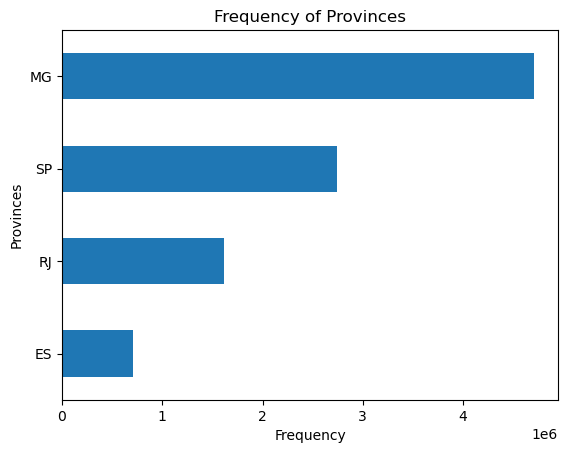

In [19]:
city_counts = df['prov'].value_counts()

city_counts.sort_values(ascending=True).plot(kind='barh')
plt.title("Frequency of Provinces")
plt.xlabel("Frequency")
plt.ylabel("Provinces")
plt.show()

In [21]:
print(df[df['prov'] == 'ES']['prov'].value_counts())

prov
ES    704472
Name: count, dtype: int64


In [22]:
esdf = df[df["prov"] == "ES"].copy()
esdf.head()

,wsid,wsnm,elvt,lat,lon,inme,city,prov,mdct,date,...,tmax,dmax,tmin,dmin,hmdy,hmax,hmin,wdsp,wdct,gust
78048,303,VITÓRIA,9.0,-20.271094,-40.306069,A612,Vitória,ES,2006-10-31 00:00:00,2006-10-31,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
78049,303,VITÓRIA,9.0,-20.271094,-40.306069,A612,Vitória,ES,2006-10-31 01:00:00,2006-10-31,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
78050,303,VITÓRIA,9.0,-20.271094,-40.306069,A612,Vitória,ES,2006-10-31 02:00:00,2006-10-31,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
78051,303,VITÓRIA,9.0,-20.271094,-40.306069,A612,Vitória,ES,2006-10-31 03:00:00,2006-10-31,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
78052,303,VITÓRIA,9.0,-20.271094,-40.306069,A612,Vitória,ES,2006-10-31 04:00:00,2006-10-31,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [23]:
esdf['mdct'] = pd.to_datetime(esdf['mdct'])
esdf['date'] = pd.to_datetime(esdf['date'])

In [24]:
esdf.dtypes 

wsid             int64
wsnm            object
elvt           float64
lat            float64
lon            float64
inme            object
city            object
prov            object
mdct    datetime64[ns]
date    datetime64[ns]
yr               int64
mo               int64
day              int64
hr               int64
prcp           float64
stp            float64
smax           float64
smin           float64
gbrd           float64
temp           float64
dewp           float64
tmax           float64
dmax           float64
tmin           float64
dmin           float64
hmdy           float64
hmax           float64
hmin           float64
wdsp           float64
wdct           float64
gust           float64
dtype: object

In [25]:
esdf.tail()

,wsid,wsnm,elvt,lat,lon,inme,city,prov,mdct,date,...,tmax,dmax,tmin,dmin,hmdy,hmax,hmin,wdsp,wdct,gust
782515,311,AFONSO CLAUDIO,507.0,-20.104194,-41.106861,A657,Afonso Cláudio,ES,2016-09-30 19:00:00,2016-09-30,...,25.4,16.7,25.0,16.3,59.0,59.0,58.0,2.3,45.0,4.8
782516,311,AFONSO CLAUDIO,507.0,-20.104194,-41.106861,A657,Afonso Cláudio,ES,2016-09-30 20:00:00,2016-09-30,...,25.3,16.7,24.2,15.7,59.0,59.0,57.0,3.9,95.0,5.5
782517,311,AFONSO CLAUDIO,507.0,-20.104194,-41.106861,A657,Afonso Cláudio,ES,2016-09-30 21:00:00,2016-09-30,...,24.2,16.1,22.3,15.7,67.0,67.0,59.0,4.0,160.0,7.1
782518,311,AFONSO CLAUDIO,507.0,-20.104194,-41.106861,A657,Afonso Cláudio,ES,2016-09-30 22:00:00,2016-09-30,...,22.3,16.0,21.1,15.7,71.0,72.0,67.0,3.2,168.0,7.7
782519,311,AFONSO CLAUDIO,507.0,-20.104194,-41.106861,A657,Afonso Cláudio,ES,2016-09-30 23:00:00,2016-09-30,...,21.3,15.7,20.4,14.7,70.0,71.0,69.0,4.1,174.0,6.9


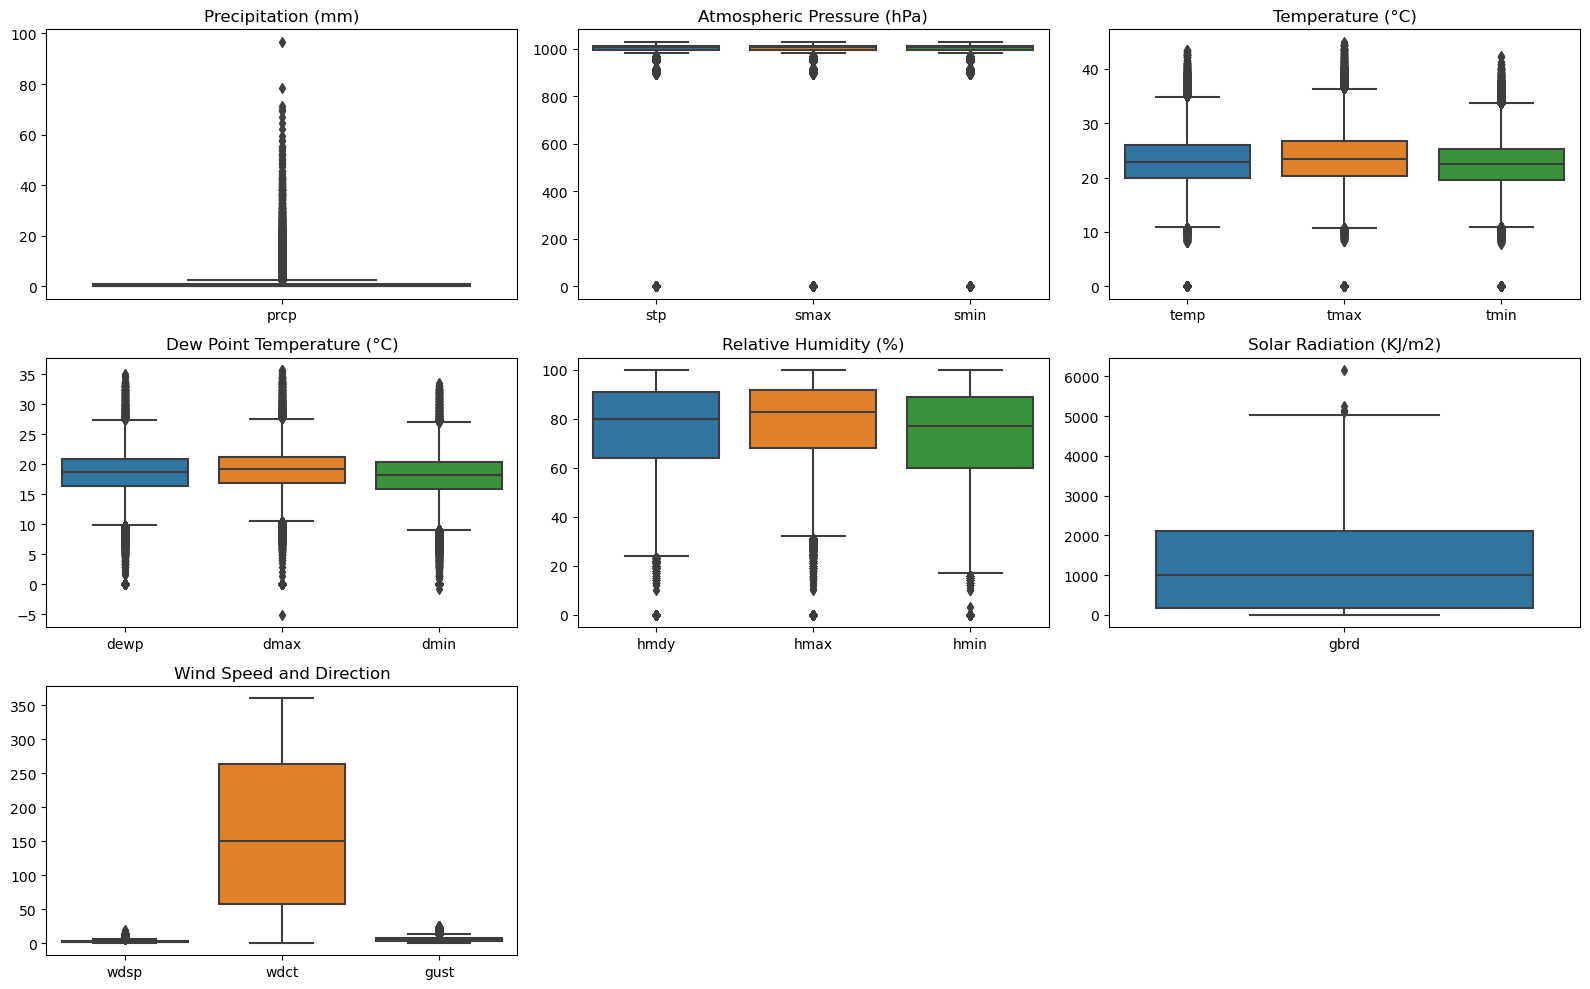

In [26]:
# Group features
weather_conditions = ['prcp']
atmospheric_pressure = ['stp', 'smax', 'smin']
temperature = ['temp', 'tmax', 'tmin']
dew_point = ['dewp', 'dmax', 'dmin']
humidity = ['hmdy', 'hmax', 'hmin']
solar_radiation = ['gbrd']
wind = ['wdsp', 'wdct', 'gust']

# Plot boxplots for each group
plt.figure(figsize=(16, 10))

# Weather conditions
plt.subplot(3, 3, 1)
sns.boxplot(data=esdf[weather_conditions])
plt.title('Precipitation (mm)')

# Atmospheric pressure
plt.subplot(3, 3, 2)
sns.boxplot(data=esdf[atmospheric_pressure])
plt.title('Atmospheric Pressure (hPa)')

# Temperature
plt.subplot(3, 3, 3)
sns.boxplot(data=esdf[temperature])
plt.title('Temperature (°C)')

# Dew point
plt.subplot(3, 3, 4)
sns.boxplot(data=esdf[dew_point])
plt.title('Dew Point Temperature (°C)')

# Humidity
plt.subplot(3, 3, 5)
sns.boxplot(data=esdf[humidity])
plt.title('Relative Humidity (%)')

# Solar radiation
plt.subplot(3, 3, 6)
sns.boxplot(data=esdf[solar_radiation])
plt.title('Solar Radiation (KJ/m2)')

# Wind
plt.subplot(3, 3, 7)
sns.boxplot(data=esdf[wind])
plt.title('Wind Speed and Direction')

plt.tight_layout()
plt.show()

In [27]:
# Subset of numerical columns
numerical_cols = ['prcp', 'stp', 'smax', 'smin', 'gbrd', 'temp', 'dewp', 'tmax', 
                  'dmax', 'tmin', 'dmin', 'hmdy', 'hmax', 'hmin', 'wdsp', 'wdct', 'gust']

# Print count of occurrences of 0.0 for each numerical column
for col in numerical_cols:
    zero_count = esdf[esdf[col] == 0.0][col].count()
    print(f"Count of occurrences of 0.0 in {col}: {zero_count}")

Count of occurrences of 0.0 in prcp: 28396
Count of occurrences of 0.0 in stp: 25030
Count of occurrences of 0.0 in smax: 25305
Count of occurrences of 0.0 in smin: 25305
Count of occurrences of 0.0 in gbrd: 39592
Count of occurrences of 0.0 in temp: 21376
Count of occurrences of 0.0 in dewp: 23345
Count of occurrences of 0.0 in tmax: 21648
Count of occurrences of 0.0 in dmax: 23715
Count of occurrences of 0.0 in tmin: 21647
Count of occurrences of 0.0 in dmin: 23719
Count of occurrences of 0.0 in hmdy: 23346
Count of occurrences of 0.0 in hmax: 23708
Count of occurrences of 0.0 in hmin: 23715
Count of occurrences of 0.0 in wdsp: 26218
Count of occurrences of 0.0 in wdct: 26241
Count of occurrences of 0.0 in gust: 26724


In [28]:
esdf.shape

(704472, 31)

In [29]:
esdf.city.unique()

array(['Vitória', 'Santa Teresa', 'Linhares', 'Alfredo Chaves',
       'São Mateus', 'Alegre', 'Presidente Kennedy', 'Nova Venécia',
       'Afonso Cláudio'], dtype=object)

In [30]:
esdf.isnull().sum()

wsid         0
wsnm         0
elvt         0
lat          0
lon          0
inme         0
city         0
prov         0
mdct         0
date         0
yr           0
mo           0
day          0
hr           0
prcp    617674
stp          0
smax         0
smin         0
gbrd    298768
temp         0
dewp         0
tmax         0
dmax         0
tmin         0
dmin         0
hmdy         0
hmax         0
hmin         0
wdsp      6680
wdct         0
gust      1723
dtype: int64

In [31]:
esdf.head()

,wsid,wsnm,elvt,lat,lon,inme,city,prov,mdct,date,...,tmax,dmax,tmin,dmin,hmdy,hmax,hmin,wdsp,wdct,gust
78048,303,VITÓRIA,9.0,-20.271094,-40.306069,A612,Vitória,ES,2006-10-31 00:00:00,2006-10-31,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
78049,303,VITÓRIA,9.0,-20.271094,-40.306069,A612,Vitória,ES,2006-10-31 01:00:00,2006-10-31,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
78050,303,VITÓRIA,9.0,-20.271094,-40.306069,A612,Vitória,ES,2006-10-31 02:00:00,2006-10-31,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
78051,303,VITÓRIA,9.0,-20.271094,-40.306069,A612,Vitória,ES,2006-10-31 03:00:00,2006-10-31,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
78052,303,VITÓRIA,9.0,-20.271094,-40.306069,A612,Vitória,ES,2006-10-31 04:00:00,2006-10-31,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Checking for City Counts

In [33]:
city_counts.unique

<bound method Series.unique of city
Rio de Janeiro           302352
Campos dos Goytacazes    160584
Seropédica               143376
Bauru                    132264
Campos do Jordão         127584
                          ...  
Saquarema                  9480
Rio Claro                  2880
Três Rios                  2760
Sete Lagoas                2712
Januária                   2400
Name: count, Length: 117, dtype: int64>

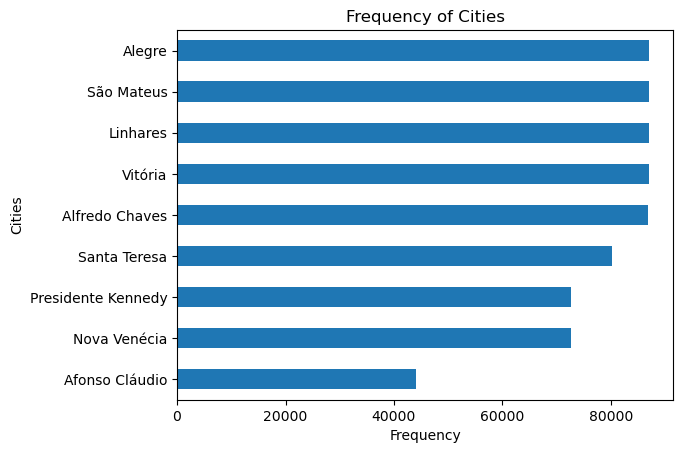

In [34]:
city_counts = esdf['city'].value_counts()

city_counts.sort_values(ascending=True).plot(kind='barh')
plt.title("Frequency of Cities")
plt.xlabel("Frequency")
plt.ylabel("Cities")
plt.show()

#### Identifying Zero Values

In [36]:
mask_zero_temp = esdf['temp'].isin([0])
rows_with_zero_temp = esdf[mask_zero_temp]
num_rows_with_zero_temp = mask_zero_temp.sum()
print(f"Number of rows with 0 in the 'temp' column: {num_rows_with_zero_temp}")

Number of rows with 0 in the 'temp' column: 21376


let's check which city has 0 values

In [38]:
mask_zero_temp = esdf['temp'] == 0
rows_with_zero_temp = esdf[mask_zero_temp]
zero_temp_by_city = rows_with_zero_temp.groupby('city').size()
print(zero_temp_by_city)

city
Afonso Cláudio        1716
Alegre                2689
Alfredo Chaves        1165
Linhares              3304
Nova Venécia           809
Presidente Kennedy    5464
Santa Teresa          3520
São Mateus            1682
Vitória               1027
dtype: int64


We can see that it is a problem that there are values of 0s in the temperature which is unlikely

#### Interpolation for Zero Values

In [41]:
esdf.sort_values('mdct', inplace=True)
esdf['temp'] = pd.to_numeric(esdf['temp'], errors='coerce')
esdf['temp'].replace(0, float('nan'), inplace=True)  
esdf['temp'] = esdf['temp'].astype(float)

In [42]:
esdf['temp'] = esdf['temp'].interpolate(method='linear')

In [43]:
esdf.sort_values('mdct', inplace=True)
esdf['temp'] = pd.to_numeric(esdf['temp'], errors='coerce')
esdf['temp'].replace(0, float('nan'), inplace=True)  
esdf['temp'] = esdf['temp'].astype(float) 

In [44]:
esdf['temp'] = esdf['temp'].interpolate(method='linear')

It seems that there are datapoints left even after interpolating

In [46]:
nan_count = esdf['temp'].isna().sum()

# Print the count
print(f"Number of NaN values in 'temp' column: {nan_count}")

Number of NaN values in 'temp' column: 30


In [47]:
nan_indices = esdf[esdf['temp'].isna()].index

# Print the list of indices
print(nan_indices)

Index([419112, 506208, 419113, 506209, 419114, 506210, 419115, 506211, 506212,
       419116, 506213, 419117, 506214, 419118, 506215, 419119, 506216, 419120,
       506217, 419121, 419122, 506218, 506219, 419123, 506220, 419124, 506221,
       419125, 419126, 506222],
      dtype='int64')


In [48]:
esdf['temp'].ffill(inplace=True)

# Backward fill to impute any remaining NaN values
esdf['temp'].bfill(inplace=True)

In [49]:
nan_count_after = esdf['temp'].isna().sum()

In [50]:
print(f"Number of NaN values in 'temp' column after imputation: {nan_count_after}")

Number of NaN values in 'temp' column after imputation: 0


Great! there are no more NAN values

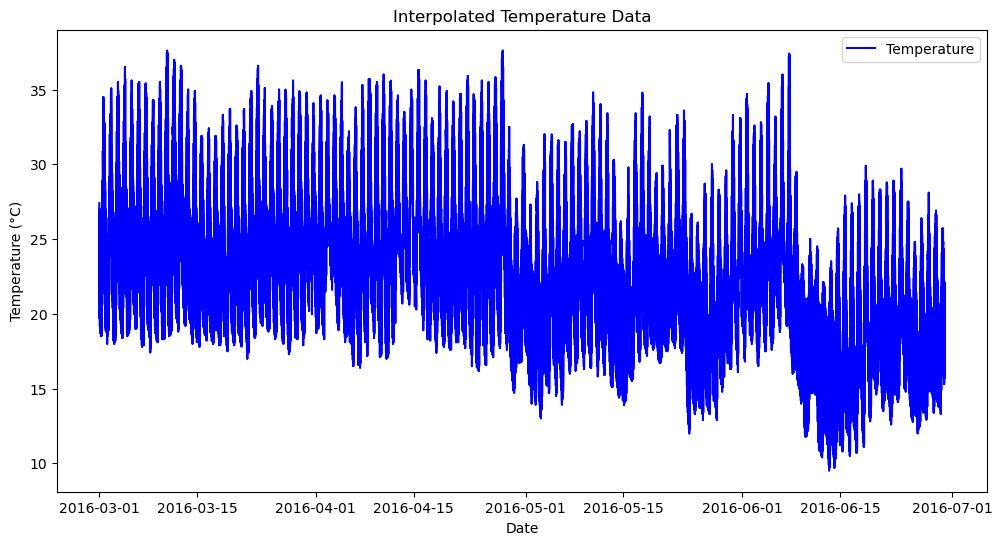

In [53]:
plot_data = esdf[(esdf['mdct'] > '2016-03-01') & (esdf['mdct'] < '2016-06-30')]
plt.figure(figsize=(12, 6))
plt.plot(plot_data['mdct'], plot_data['temp'], label='Temperature', color='blue')
plt.title('Interpolated Temperature Data')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.show()

#### Rechecking Again for Zero Values

In [55]:
mask_zero_temp = esdf['temp'].isin([0])
rows_with_zero_temp = esdf[mask_zero_temp]
num_rows_with_zero_temp = mask_zero_temp.sum()
print(f"Number of rows with 0 in the 'temp' column: {num_rows_with_zero_temp}")

Number of rows with 0 in the 'temp' column: 0


Great! There are no more 0 Values

#### Investigating Time Series for Each City

In [58]:
time_range_per_city = esdf.groupby('city')['mdct'].agg(['min', 'max'])

In [59]:
time_range_per_city['duration'] = time_range_per_city['max'] - time_range_per_city['min']
time_range_per_city_sorted = time_range_per_city.sort_values(by='duration', ascending=True)

In [60]:
print(time_range_per_city_sorted)

                          min                 max           duration
city                                                                
Afonso Cláudio     2011-09-24 2016-09-30 23:00:00 1833 days 23:00:00
Nova Venécia       2008-06-22 2016-09-30 23:00:00 3022 days 23:00:00
Presidente Kennedy 2008-06-18 2016-09-30 23:00:00 3026 days 23:00:00
Santa Teresa       2007-08-09 2016-09-30 23:00:00 3340 days 23:00:00
Alfredo Chaves     2006-11-03 2016-09-30 23:00:00 3619 days 23:00:00
Vitória            2006-10-31 2016-09-30 23:00:00 3622 days 23:00:00
Linhares           2006-10-27 2016-09-30 23:00:00 3626 days 23:00:00
Alegre             2006-10-25 2016-09-30 23:00:00 3628 days 23:00:00
São Mateus         2006-10-25 2016-09-30 23:00:00 3628 days 23:00:00


#### Temperatures of Afonso Cláudio

In [62]:
afonso_data = esdf[esdf['city'] == 'Afonso Cláudio']
afonso_data_sorted = afonso_data.sort_values('mdct')

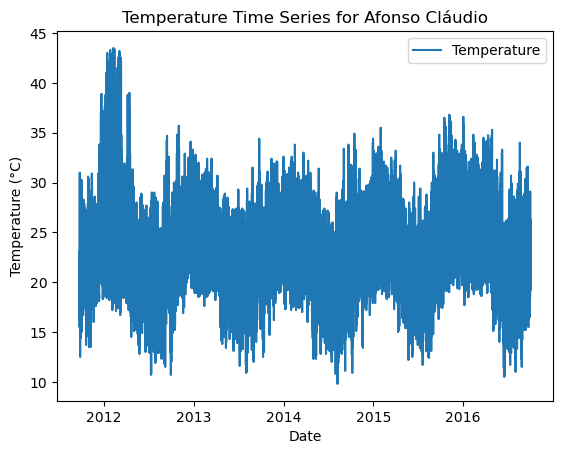

In [63]:
plt.plot(afonso_data_sorted['mdct'], afonso_data_sorted['temp'], label='Temperature')
plt.title('Temperature Time Series for Afonso Cláudio')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.show()


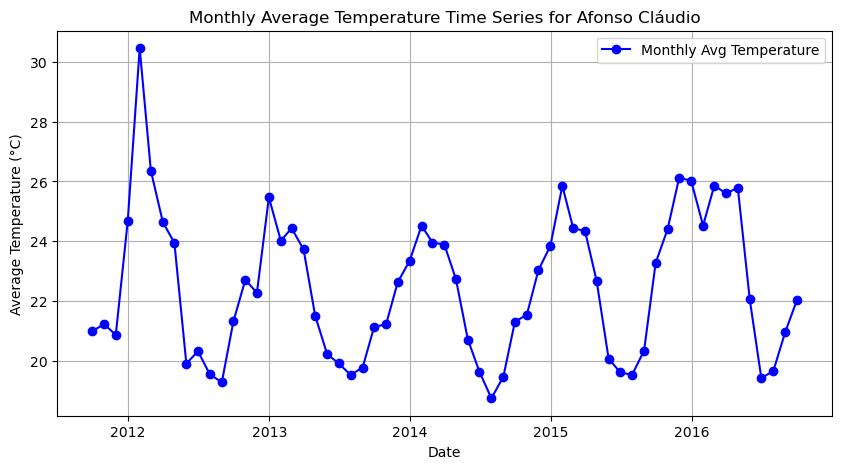

In [64]:
monthly_temp = afonso_data_sorted.resample('M', on='mdct')['temp'].mean()

# Plotting the monthly average temperatures
plt.figure(figsize=(10, 5))  # Optional: Adjust figure size for better readability
plt.plot(monthly_temp.index, monthly_temp, label='Monthly Avg Temperature', color='blue', marker='o')
plt.title('Monthly Average Temperature Time Series for Afonso Cláudio')
plt.xlabel('Date')
plt.ylabel('Average Temperature (°C)')
plt.legend()
plt.grid(True)  # Optional: Adds grid lines for better visual guidance
plt.show()


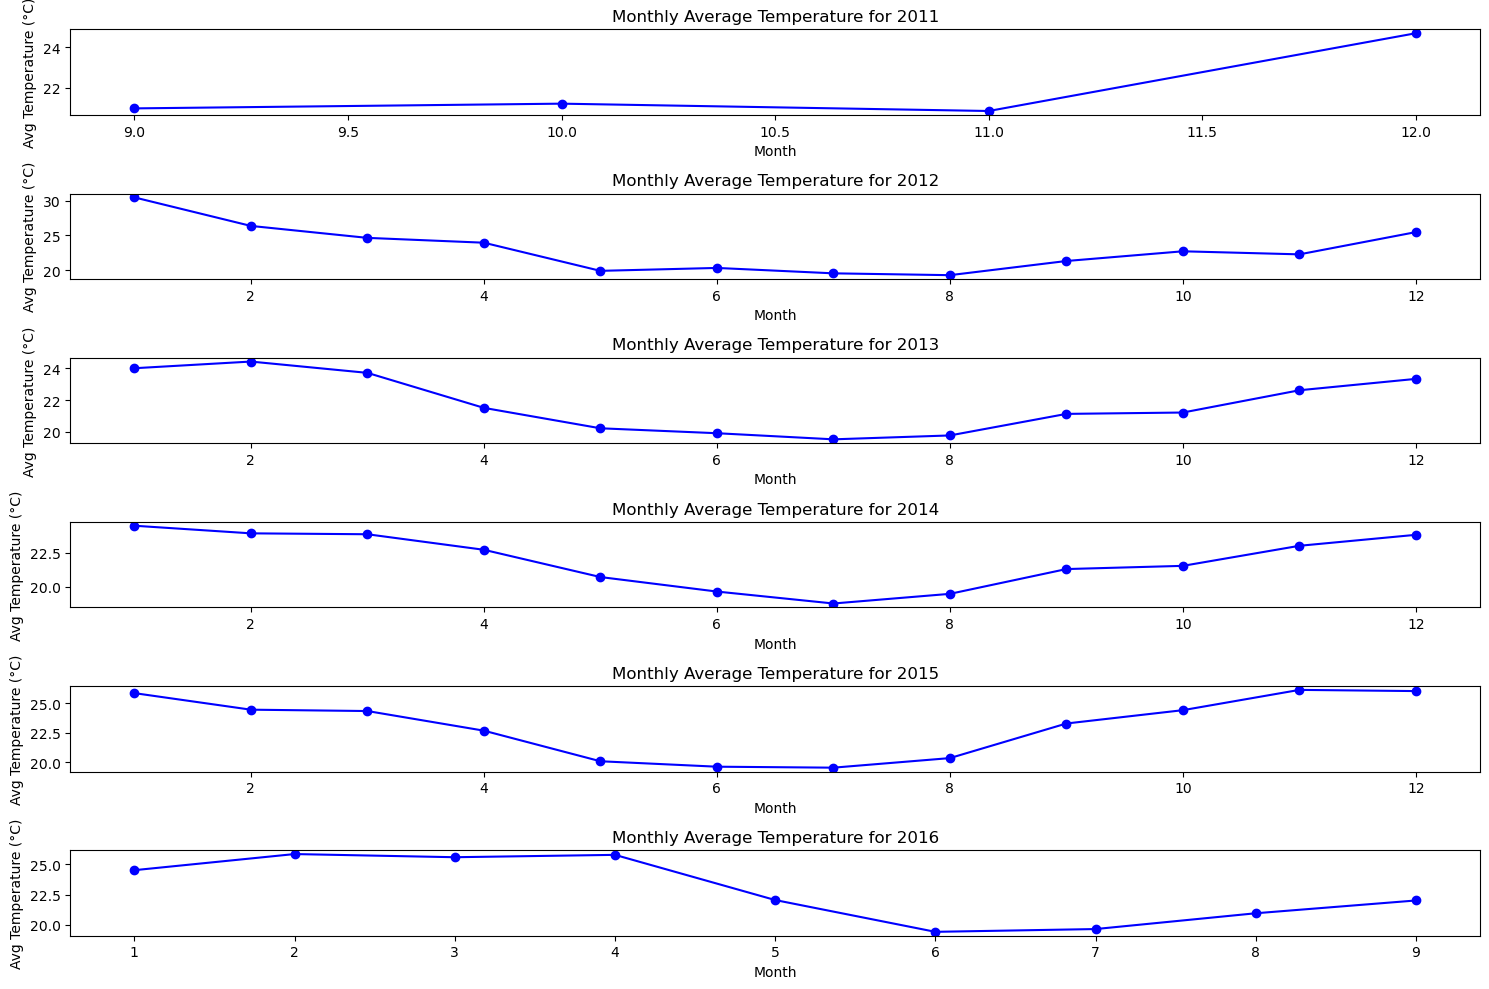

In [65]:
monthly_temp = afonso_data_sorted.resample('M', on='mdct')['temp'].mean()
years = monthly_temp.index.year.unique()
plt.figure(figsize=(15, 10))  
for i, year in enumerate(years):
    plt.subplot(len(years), 1, i + 1)
    yearly_data = monthly_temp[monthly_temp.index.year == year]
    plt.plot(yearly_data.index.month, yearly_data, marker='o', linestyle='-', color='blue')
    plt.title(f'Monthly Average Temperature for {year}')
    plt.xlabel('Month')
    plt.ylabel('Avg Temperature (°C)')
    plt.tight_layout()
plt.show()

#### Temperatures of Nova Venécia

In [67]:
nova_data = esdf[esdf['city'] == 'Nova Venécia']
nova_data_sorted = nova_data.sort_values('mdct')

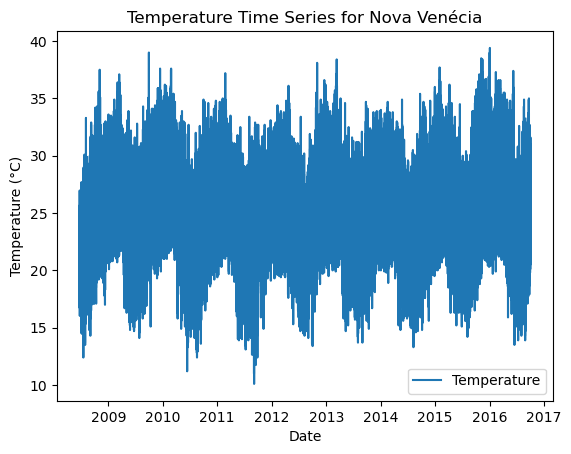

In [68]:
plt.plot(nova_data_sorted['mdct'], nova_data_sorted['temp'], label='Temperature')
plt.title('Temperature Time Series for Nova Venécia')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.show()


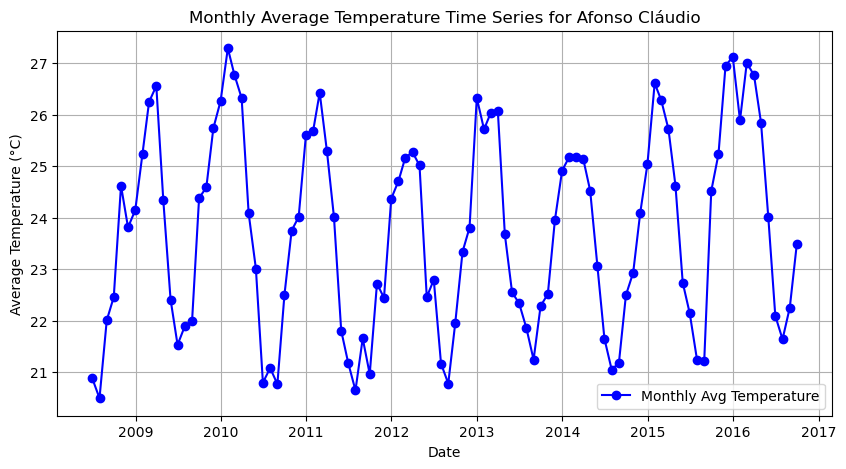

In [69]:
monthly_temp_nova = nova_data_sorted.resample('M', on='mdct')['temp'].mean()

# Plotting the monthly average temperatures
plt.figure(figsize=(10, 5))  # Optional: Adjust figure size for better readability
plt.plot(monthly_temp_nova.index, monthly_temp_nova, label='Monthly Avg Temperature', color='blue', marker='o')
plt.title('Monthly Average Temperature Time Series for Afonso Cláudio')
plt.xlabel('Date')
plt.ylabel('Average Temperature (°C)')
plt.legend()
plt.grid(True)  # Optional: Adds grid lines for better visual guidance
plt.show()


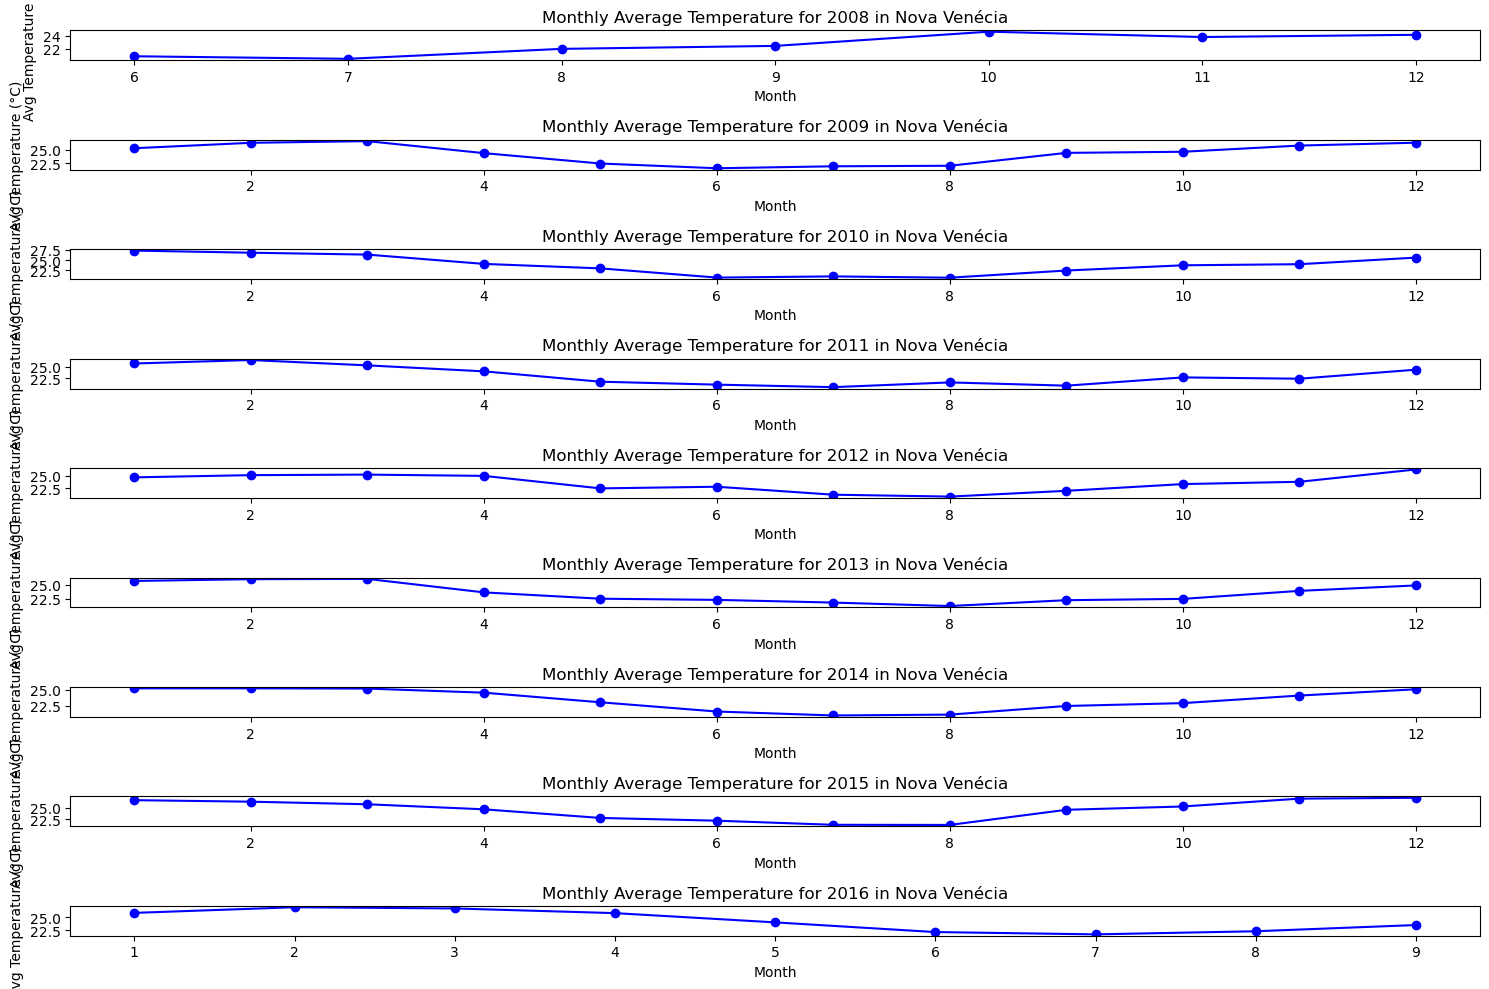

In [70]:
monthly_temp_nv = nova_data_sorted.resample('M', on='mdct')['temp'].mean()

# Extract years from the data for creating subplots
years_nv = monthly_temp_nv.index.year.unique()

# Set up the plotting area - adjust the size if needed
plt.figure(figsize=(15, 10))  # Adjust the size based on the number of subplots

# Create a subplot for each year
for i, year in enumerate(years_nv):
    plt.subplot(len(years_nv), 1, i + 1)  # Number of rows, number of columns, subplot index
    # Filter data for the specific year
    yearly_data_nv = monthly_temp_nv[monthly_temp_nv.index.year == year]
    
    # Plot data
    plt.plot(yearly_data_nv.index.month, yearly_data_nv, marker='o', linestyle='-', color='blue')
    plt.title(f'Monthly Average Temperature for {year} in Nova Venécia')
    plt.xlabel('Month')
    plt.ylabel('Avg Temperature (°C)')
    plt.tight_layout()  # Adjust subplots to fit into the figure area

plt.show()

#### Temperatures of Alfredo Chaves

In [72]:
alfredo_data = esdf[esdf['city'] == 'Alfredo Chaves']
alfredo_data_sorted = alfredo_data.sort_values('mdct')

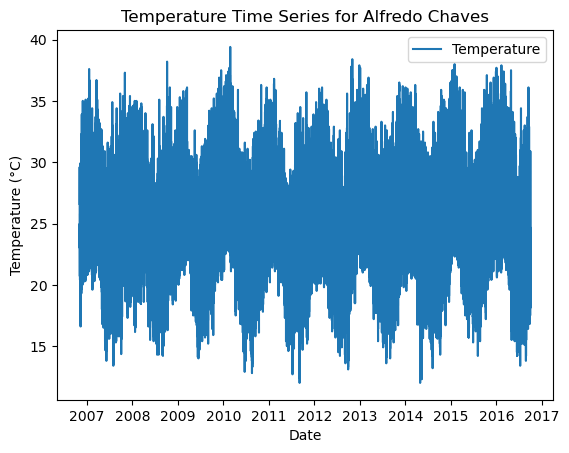

In [73]:
plt.plot(alfredo_data_sorted['mdct'], alfredo_data_sorted['temp'], label='Temperature')
plt.title('Temperature Time Series for Alfredo Chaves')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.show()


#### Temperatures Linhares   

In [75]:
linhares_data = esdf[esdf['city'] == 'Linhares']
linhares_data_sorted = linhares_data.sort_values('mdct')

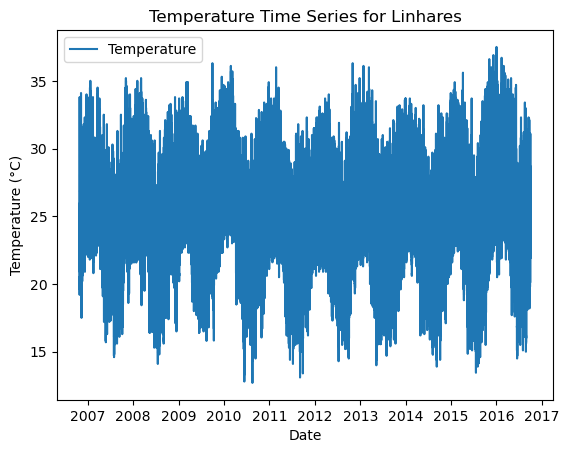

In [76]:
plt.plot(linhares_data_sorted['mdct'], linhares_data_sorted['temp'], label='Temperature')
plt.title('Temperature Time Series for Linhares')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.show()


#### Temperatures of Presidente Kennedy

In [78]:
kennedy_data = esdf[esdf['city'] == 'Presidente Kennedy']
kennedy_data_sorted = kennedy_data.sort_values('mdct')

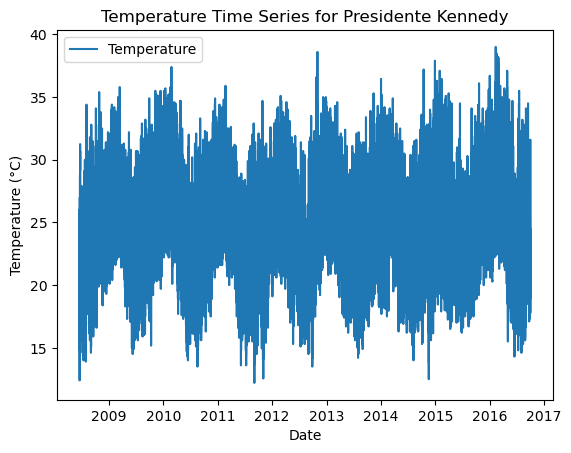

In [79]:
plt.plot(kennedy_data_sorted['mdct'], kennedy_data_sorted['temp'], label='Temperature')
plt.title('Temperature Time Series for Presidente Kennedy')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.show()


#### Temperatures of Santa Teresa

In [81]:
teresa_data = esdf[esdf['city'] == 'Santa Teresa']
teresa_data_sorted = teresa_data.sort_values('mdct')

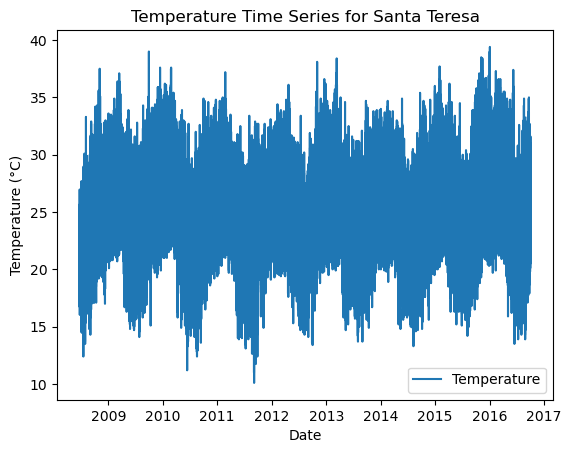

In [82]:
plt.plot(nova_data_sorted['mdct'], nova_data_sorted['temp'], label='Temperature')
plt.title('Temperature Time Series for Santa Teresa')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.show()


#### Temperatures of São Mateus

In [84]:
mateus_data = esdf[esdf['city'] == 'São Mateus']
mateus_data_sorted = mateus_data.sort_values('mdct')

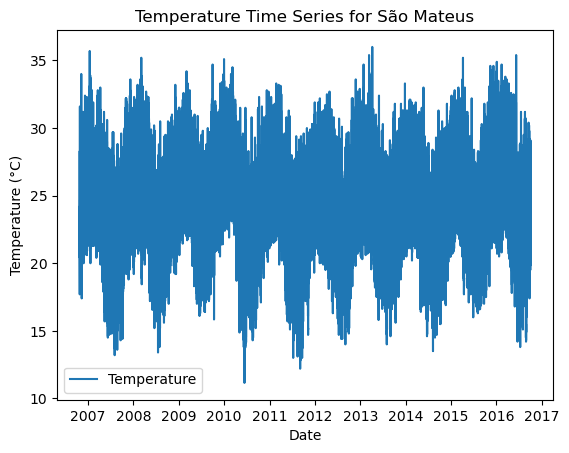

In [85]:
plt.plot(mateus_data_sorted['mdct'], mateus_data_sorted['temp'], label='Temperature')
plt.title('Temperature Time Series for São Mateus')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.show()


#### Temperatures of Vitória

In [87]:
vitoria_data = esdf[esdf['city'] == 'Vitória']
vitoria_data_sorted = vitoria_data.sort_values('mdct')

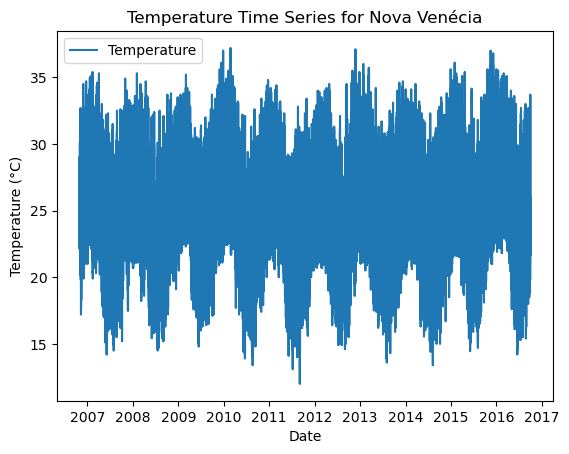

In [88]:
plt.plot(vitoria_data_sorted['mdct'], vitoria_data_sorted['temp'], label='Temperature')
plt.title('Temperature Time Series for Nova Venécia')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.show()

#### Temperatures of Alegre

In [90]:
alegres_data = esdf[esdf['city'] == 'Alegre']
alegres_data_sorted = alegres_data.sort_values('mdct')

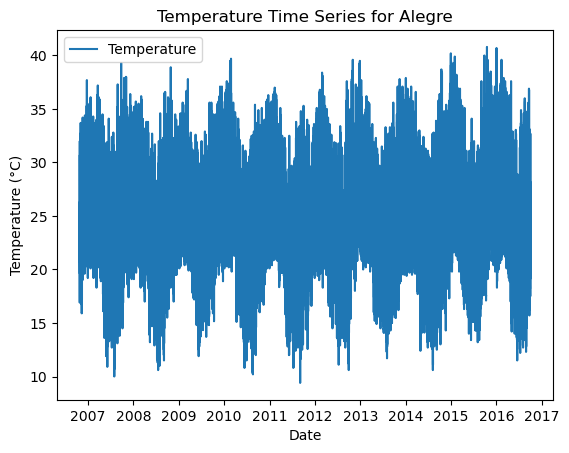

In [91]:
plt.plot(alegres_data_sorted['mdct'], alegres_data_sorted['temp'], label='Temperature')
plt.title('Temperature Time Series for Alegre')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.show()

#### Visualization of All Plots

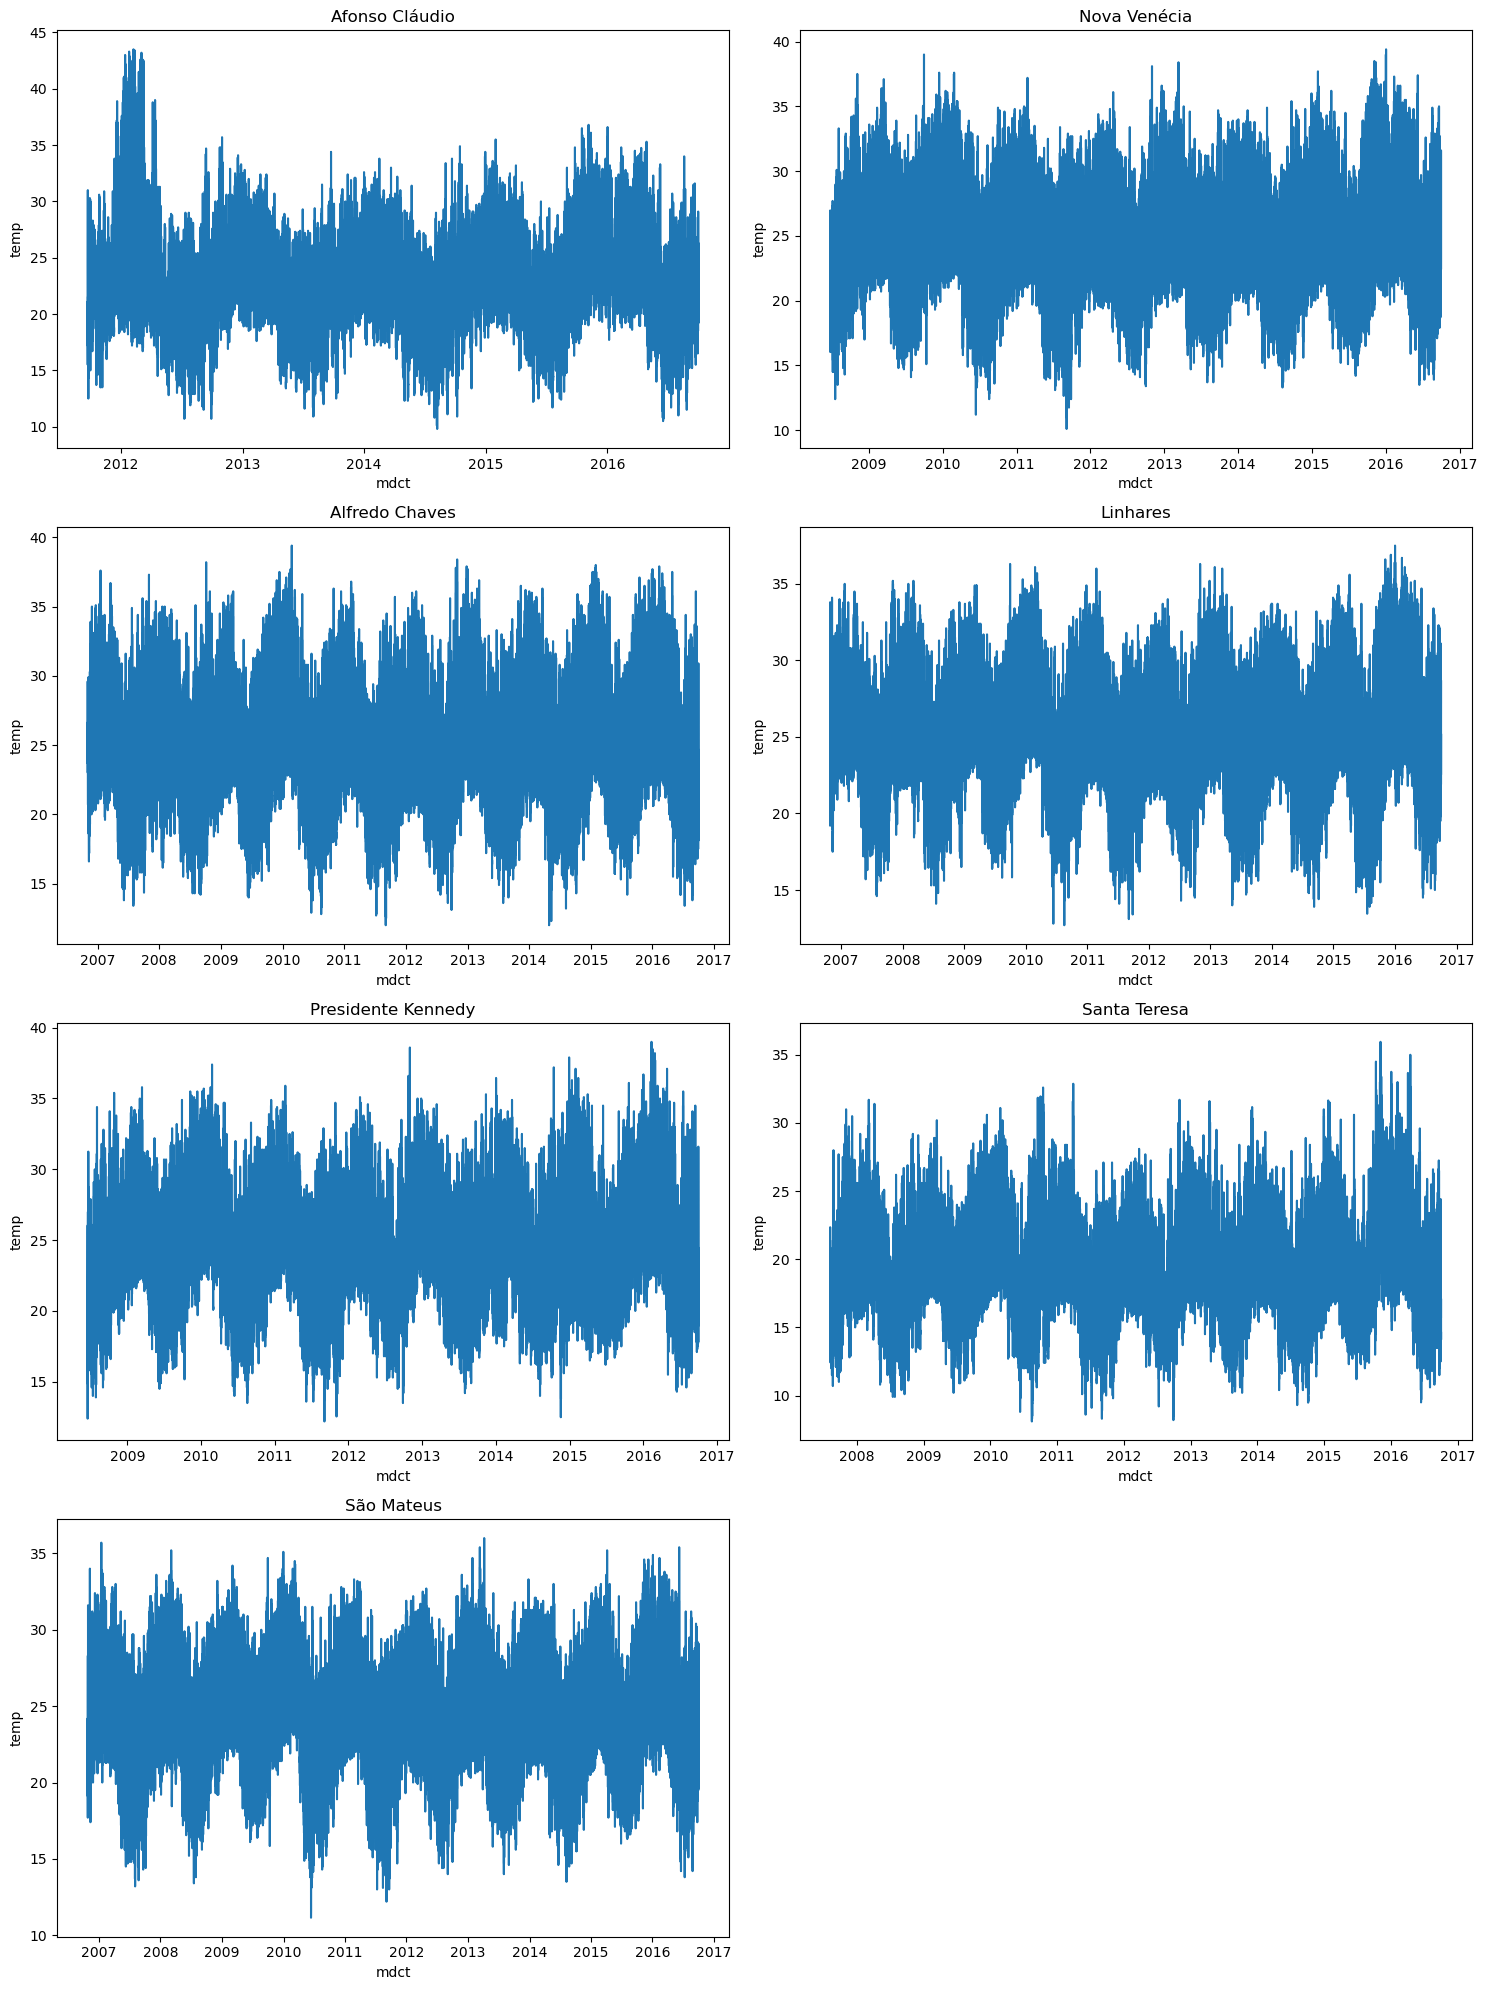

In [93]:
fig, axs = plt.subplots(4, 2, figsize=(15, 20))
axs = axs.flatten()
dataframes = [
    ('Afonso Cláudio', afonso_data_sorted),
    ('Nova Venécia', nova_data_sorted),
    ('Alfredo Chaves', alfredo_data_sorted),
    ('Linhares', linhares_data_sorted),
    ('Presidente Kennedy', kennedy_data_sorted),
    ('Santa Teresa', teresa_data_sorted),
    ('São Mateus', mateus_data_sorted),
    ('Vitória', vitoria_data_sorted)
]
for i, (city, df) in enumerate(dataframes):
    ax = axs[i]
    ax.plot(df['mdct'], df['temp'])
    ax.set_title(city)
    ax.set_xlabel('mdct')
    ax.set_ylabel('temp')
fig.delaxes(axs[-1])
plt.tight_layout()
plt.show()

In [94]:
esdf['temp'].isna().sum

<bound method Series.sum of 419112    False
506208    False
419113    False
506209    False
419114    False
          ...  
738503    False
506207    False
245183    False
332231    False
782519    False
Name: temp, Length: 704472, dtype: bool>

In [95]:
nan_indices = esdf[esdf['temp'].isna()].index

# Print the list of indices
print(nan_indices)

Index([], dtype='int64')


In [96]:
important_columns = ['yr', 'mo', 'day', 'hr', 'mdct', 'temp', 'tmax', 'tmin', 'city', 'prov']
esdf_subset = esdf[important_columns].copy()

# Display the first few rows to verify the subset
esdf_subset.head()

,yr,mo,day,hr,mdct,temp,tmax,tmin,city,prov
419112,2006,10,25,0,2006-10-25 00:00:00,22.933333,0.0,0.0,São Mateus,ES
506208,2006,10,25,0,2006-10-25 00:00:00,22.933333,0.0,0.0,Alegre,ES
419113,2006,10,25,1,2006-10-25 01:00:00,22.933333,0.0,0.0,São Mateus,ES
506209,2006,10,25,1,2006-10-25 01:00:00,22.933333,0.0,0.0,Alegre,ES
419114,2006,10,25,2,2006-10-25 02:00:00,22.933333,0.0,0.0,São Mateus,ES


In [97]:
esdf_subset.head()

,yr,mo,day,hr,mdct,temp,tmax,tmin,city,prov
419112,2006,10,25,0,2006-10-25 00:00:00,22.933333,0.0,0.0,São Mateus,ES
506208,2006,10,25,0,2006-10-25 00:00:00,22.933333,0.0,0.0,Alegre,ES
419113,2006,10,25,1,2006-10-25 01:00:00,22.933333,0.0,0.0,São Mateus,ES
506209,2006,10,25,1,2006-10-25 01:00:00,22.933333,0.0,0.0,Alegre,ES
419114,2006,10,25,2,2006-10-25 02:00:00,22.933333,0.0,0.0,São Mateus,ES


In [98]:
len(esdf_subset['prov'].unique())

1

In [99]:
esdf_subset.shape

(704472, 10)

In [100]:
esdf_subset_sorted = esdf_subset.sort_values(by=['city', 'yr', 'mo', 'day', 'hr'])

In [101]:
esdf_subset_sorted = esdf_subset_sorted.reset_index(drop=True)

In [102]:
esdf_subset_sorted.head()

,yr,mo,day,hr,mdct,temp,tmax,tmin,city,prov
0,2011,9,24,0,2011-09-24 00:00:00,20.400000,0.0,0.0,Afonso Cláudio,ES
1,2011,9,24,1,2011-09-24 01:00:00,19.650000,0.0,0.0,Afonso Cláudio,ES
2,2011,9,24,2,2011-09-24 02:00:00,19.500000,0.0,0.0,Afonso Cláudio,ES
3,2011,9,24,3,2011-09-24 03:00:00,21.100000,0.0,0.0,Afonso Cláudio,ES
4,2011,9,24,4,2011-09-24 04:00:00,15.733333,0.0,0.0,Afonso Cláudio,ES


In [103]:
data = esdf_subset_sorted

In [104]:
esdf_subset_sorted.to_csv('output.csv', index=False)

#### Feature Extraction for Season Checking

The coastal region of Espírito Santo experiences a predominantly warm, tropical climate, characterized by two primary seasons: the wet season, spanning from October to January, and the dry season, which extends from February to September. The peak of rainfall typically occurs in December, with precipitation levels reaching up to 7.1 inches (180 millimeters), while the driest month is June, with a mere 2 inches (50 millimeters) of rainfall. In comparison to other regions in Brazil, the rainy season in Espírito Santo is relatively brief and exhibits lower precipitation levels. (Aventura do Brasil, 2021)

It seems that there are only two seasons in ES, Brazil

In [108]:
def assign_es_season(month):
    if month in [10, 11, 12, 1]:
        return 'Rainy Season'
    else:
        return 'Dry Season'
data['season'] = data['mo'].apply(assign_es_season)
data.head().head()

,yr,mo,day,hr,mdct,temp,tmax,tmin,city,prov,season
0,2011,9,24,0,2011-09-24 00:00:00,20.400000,0.0,0.0,Afonso Cláudio,ES,Dry Season
1,2011,9,24,1,2011-09-24 01:00:00,19.650000,0.0,0.0,Afonso Cláudio,ES,Dry Season
2,2011,9,24,2,2011-09-24 02:00:00,19.500000,0.0,0.0,Afonso Cláudio,ES,Dry Season
3,2011,9,24,3,2011-09-24 03:00:00,21.100000,0.0,0.0,Afonso Cláudio,ES,Dry Season
4,2011,9,24,4,2011-09-24 04:00:00,15.733333,0.0,0.0,Afonso Cláudio,ES,Dry Season


#### Graphing The Cities by Months

In [110]:
data['mdct'] = pd.to_datetime(data['mdct'])
city_groups = data.groupby('city').resample('M', on='mdct')['temp'].mean()
cities = data['city'].unique()
len(cities), cities

(9,
 array(['Afonso Cláudio', 'Alegre', 'Alfredo Chaves', 'Linhares',
        'Nova Venécia', 'Presidente Kennedy', 'Santa Teresa', 'São Mateus',
        'Vitória'], dtype=object))

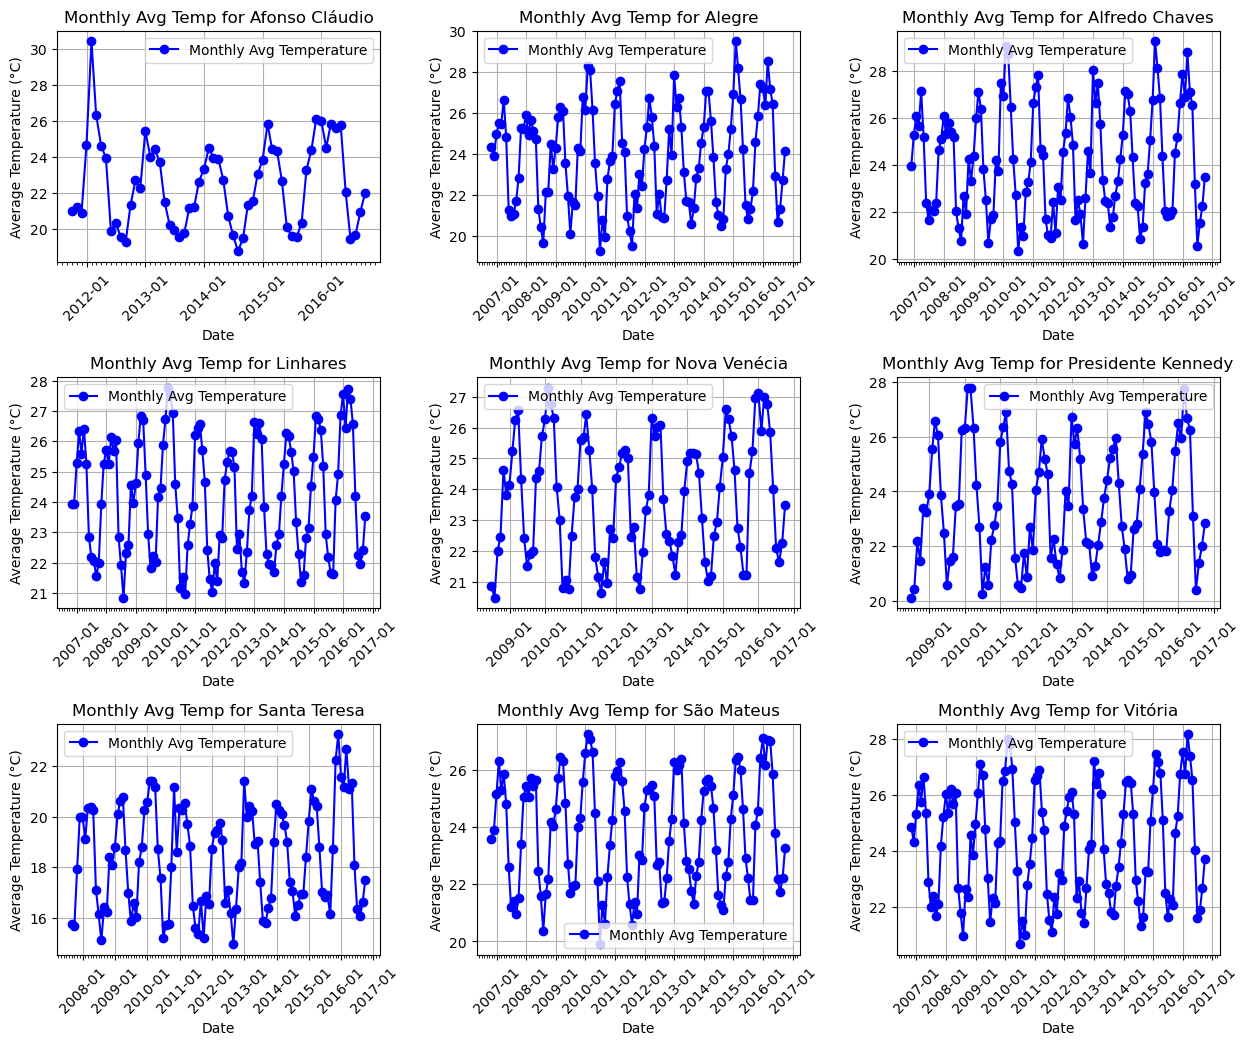

In [111]:
fig, axs = plt.subplots(3, 3, figsize=(15, 12)) 
fig.subplots_adjust(hspace=0.5, wspace=0.3)
axs = axs.flatten()

# Plotting the monthly average temperatures for each city
for i, city in enumerate(cities):
    ax = axs[i]
    monthly_temp = city_groups.loc[city]
    ax.plot(monthly_temp.index, monthly_temp, label='Monthly Avg Temperature', color='blue', marker='o')

    # Set titles and labels
    ax.set_title(f'Monthly Avg Temp for {city}')
    ax.set_xlabel('Date')
    ax.set_ylabel('Average Temperature (°C)')
    ax.legend()
    ax.grid(True)

    # Format x-axis
    ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    ax.xaxis.set_minor_locator(mdates.MonthLocator())
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)

# Show the plot
plt.show()

### Expected Results

A working `tensorflow` and traditional time series `statsmodels` (or any other applicable libraries) showing results comparison, and implications on the performance between two models.

#### Alegre Focus

In [115]:
data['mdct'] = pd.to_datetime(data['mdct'])

In [116]:
data.set_index('mdct', inplace=True)

In [117]:
alegre_data = data[data['city'] == 'Alegre']

In [118]:
monthly_data = alegre_data['temp'].resample('M').mean()

In [119]:
train_end = monthly_data.index.max() - pd.DateOffset(months=24)  # Last 24 months as test data
train_data = monthly_data[monthly_data.index <= train_end]
test_data = monthly_data[monthly_data.index > train_end]

#### Monthly Average Temperature in Alegre

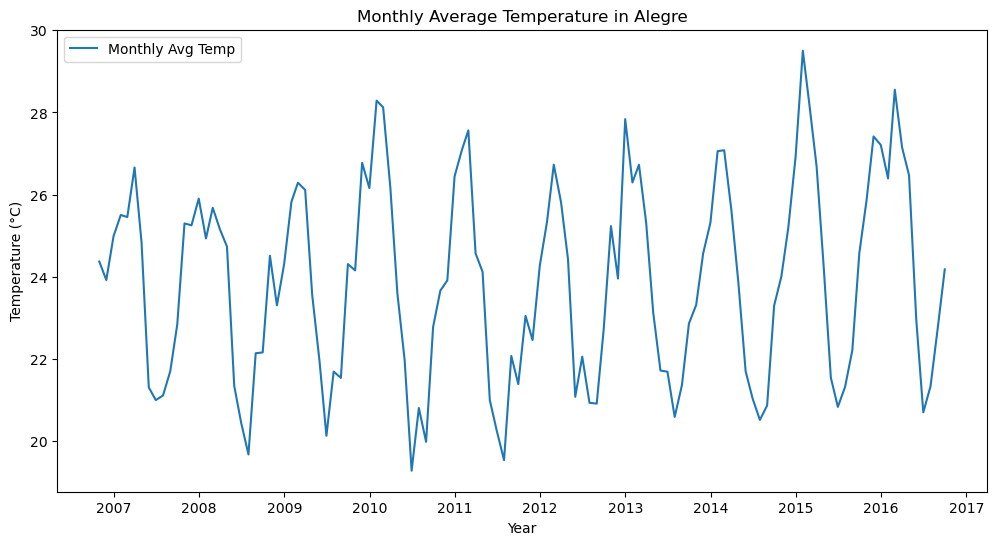

In [121]:
plt.figure(figsize=(12, 6))
plt.plot(monthly_data, label='Monthly Avg Temp')
plt.title('Monthly Average Temperature in Alegre')
plt.xlabel('Year')
plt.ylabel('Temperature (°C)')
plt.legend(loc='best')
plt.show()

#### Stationary Testing

In [123]:
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries.dropna(), autolag='AIC')  # Handling any NaNs
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [124]:
test_stationarity(monthly_data)

Results of Dickey-Fuller Test:
Test Statistic                  -0.942192
p-value                          0.773761
#Lags Used                      10.000000
Number of Observations Used    109.000000
Critical Value (1%)             -3.491818
Critical Value (5%)             -2.888444
Critical Value (10%)            -2.581120
dtype: float64


In [125]:
diff_series = monthly_data.diff().dropna()

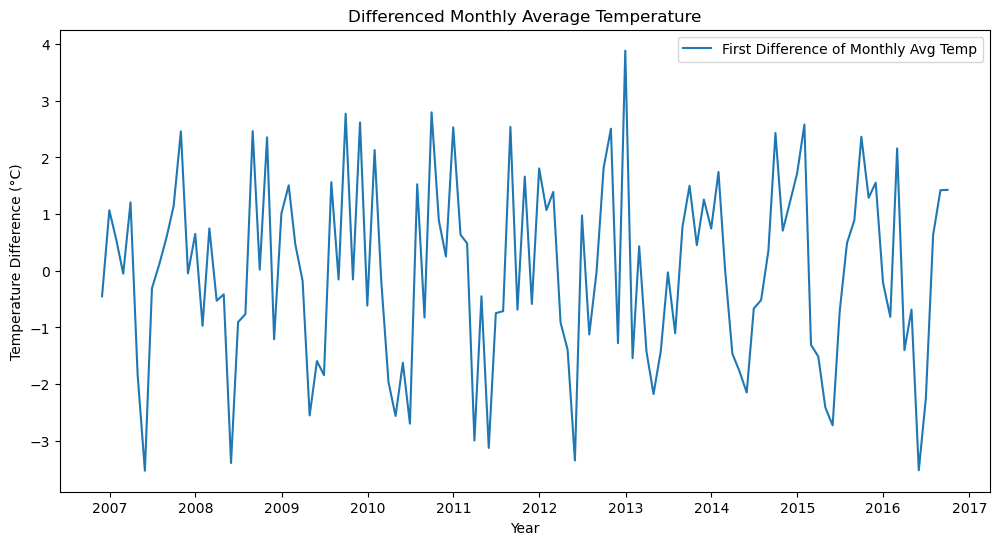

In [126]:
plt.figure(figsize=(12, 6))
plt.plot(diff_series, label='First Difference of Monthly Avg Temp')
plt.title('Differenced Monthly Average Temperature')
plt.xlabel('Year')
plt.ylabel('Temperature Difference (°C)')
plt.legend(loc='best')
plt.show()


In [127]:
test_stationarity(diff_series)

Results of Dickey-Fuller Test:
Test Statistic                -1.096477e+01
p-value                        8.155868e-20
#Lags Used                     9.000000e+00
Number of Observations Used    1.090000e+02
Critical Value (1%)           -3.491818e+00
Critical Value (5%)           -2.888444e+00
Critical Value (10%)          -2.581120e+00
dtype: float64


#### ACF and PCF Plotting

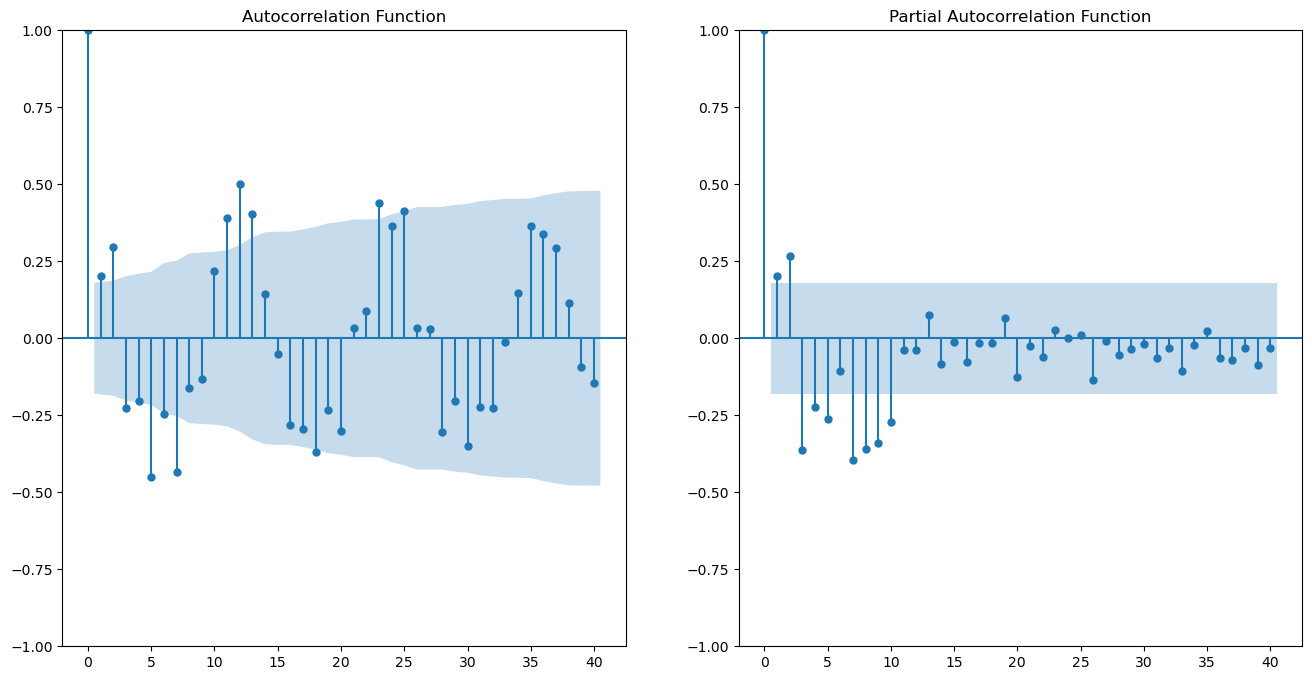

In [129]:
plt.figure(figsize=(16, 8))
plt.subplot(121)
plot_acf(diff_series, ax=plt.gca(), lags=40)
plt.title('Autocorrelation Function')

plt.subplot(122)
plot_pacf(diff_series, ax=plt.gca(), lags=40)
plt.title('Partial Autocorrelation Function')
plt.show()

Find the best model:

In [131]:
auto_arima_model = auto_arima(monthly_data, seasonal=True, m=12, trace=True, error_action='ignore', suppress_warnings=True)

# Output the summary of the best model found
print(auto_arima_model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=369.780, Time=0.39 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=553.930, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=395.028, Time=0.09 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=446.131, Time=0.08 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=1105.347, Time=0.01 sec
 ARIMA(2,0,2)(0,0,1)[12] intercept   : AIC=381.493, Time=0.30 sec
 ARIMA(2,0,2)(1,0,0)[12] intercept   : AIC=384.714, Time=0.31 sec
 ARIMA(2,0,2)(2,0,1)[12] intercept   : AIC=383.028, Time=0.62 sec
 ARIMA(2,0,2)(1,0,2)[12] intercept   : AIC=386.194, Time=0.64 sec
 ARIMA(2,0,2)(0,0,0)[12] intercept   : AIC=388.537, Time=0.19 sec
 ARIMA(2,0,2)(0,0,2)[12] intercept   : AIC=381.885, Time=0.61 sec
 ARIMA(2,0,2)(2,0,0)[12] intercept   : AIC=382.289, Time=0.54 sec
 ARIMA(2,0,2)(2,0,2)[12] intercept   : AIC=inf, Time=0.74 sec
 ARIMA(1,0,2)(1,0,1)[12] intercept   : AIC=371.188, Time=0.34 sec
 ARIMA(2,0,1)(1,0,1)[12] intercept  

#### ARIMA MODEL

In [133]:
model = SARIMAX(monthly_data, 
                order=(2, 0, 2), 
                seasonal_order=(1, 0, 1, 12), 
                enforce_stationarity=False, 
                enforce_invertibility=False)


results = model.fit()

C:\Users\paddi\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [134]:
print(results.summary())

                                      SARIMAX Results                                       
Dep. Variable:                                 temp   No. Observations:                  120
Model:             SARIMAX(2, 0, 2)x(1, 0, [1], 12)   Log Likelihood                -145.497
Date:                              Fri, 10 May 2024   AIC                            304.993
Time:                                      15:14:21   BIC                            323.571
Sample:                                  10-31-2006   HQIC                           312.521
                                       - 09-30-2016                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2598      0.208     -1.249      0.212      -0.668       0.148
ar.L2          0.49

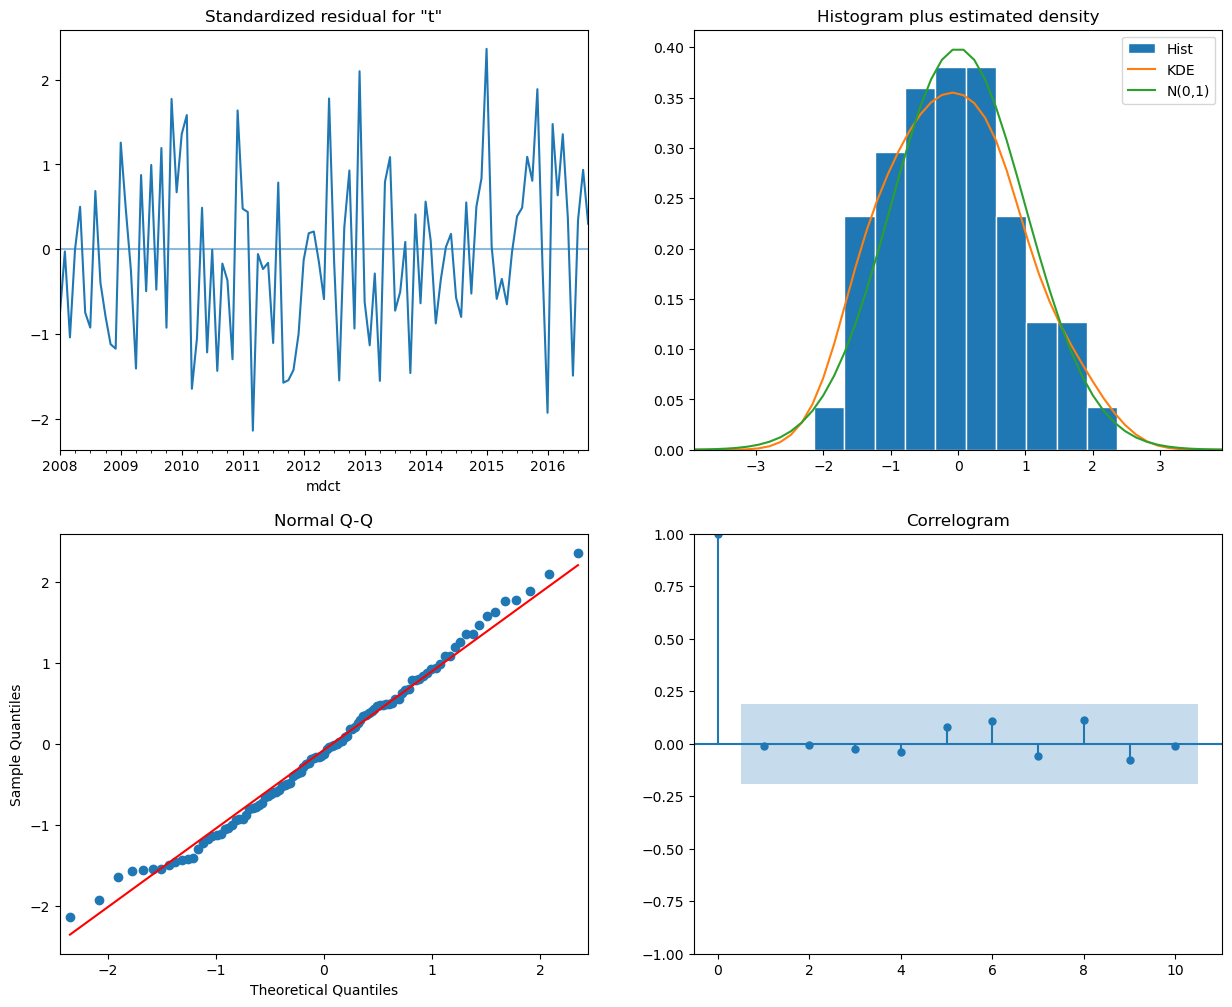

In [135]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()

Standardized Residual for "t": This likely shows how much each data point (temperature reading at a specific time) deviates from the overall trend or fitted model (e.g., ARIMA). Values around 0 indicate good model fit, while larger deviations (positive or negative) suggest potential outliers or model shortcomings.

**Histogram and Estimated Density:** This plot depicts the distribution of temperature values. The histogram shows the frequency of temperatures falling within certain ranges (bins). The smooth curve (estimated density) helps visualize the overall shape of the distribution (normal, skewed, etc.).

**Coneogram:** This is likely a combined density plot that reveals potential patterns in the temperature data. It might show clustering of values at specific temperatures or a skewed distribution.

**Normal Q-Q:** This plot compares the temperature data's quantiles to a normal distribution (bell curve). If the points fall roughly along a diagonal line, it suggests the data resembles a normal distribution. Deviations from the line indicate departures from normality, which might impact certain forecasting models.

**Correlogram:** This plot depicts the correlation between temperature and potentially other weather metrics like humidity or pressure. Strong positive or negative correlations can inform model building by highlighting potentially influential factors.

**Overall Interpretation:**

By examining these residual plots, you can gain insights into how well the chosen time series model (e.g., ARIMA) fits the temperature data. You can identify potential issues like:

**Outliers:** Data points that significantly deviate from the model's prediction.
**Non-normality:** If the data significantly deviates from a normal distribution, it might impact the accuracy of certain models like ARIMA.
**Seasonality:** The correlogram might reveal seasonal patterns in other weather metrics that could be incorporated into the model.

#### Forecasting

In [138]:
forecast_start_date = test_data.index[0]

In [139]:
forecast = results.get_forecast(steps=len(test_data))
forecast_mean = forecast.predicted_mean
forecast_conf_int = forecast.conf_int()

In [140]:
forecast_mean.index = pd.date_range(start=forecast_start_date, periods=len(test_data), freq='M')
forecast_conf_int.index = pd.date_range(start=forecast_start_date, periods=len(test_data), freq='M')

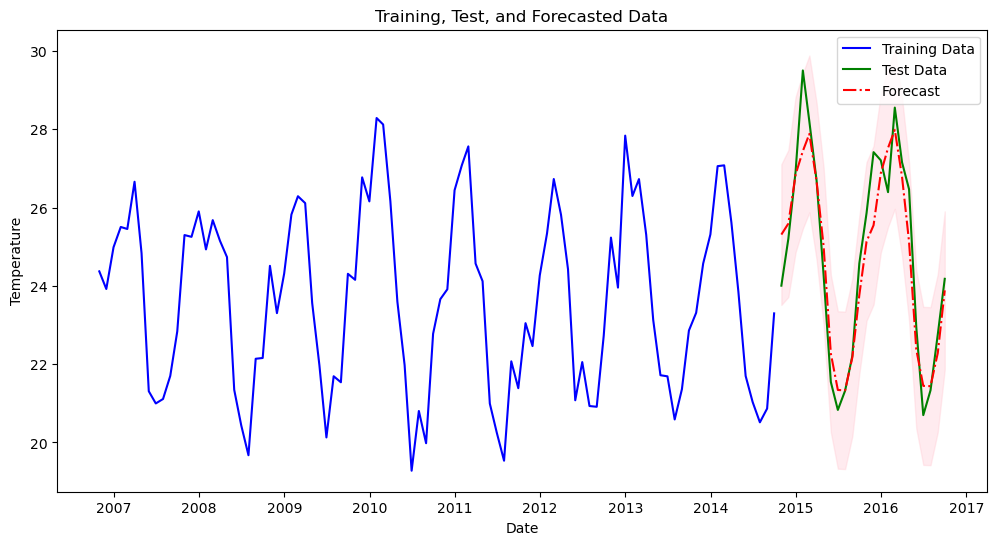

In [141]:
plt.figure(figsize=(12, 6))
plt.plot(train_data, label='Training Data', color='blue') 
plt.plot(test_data.index, test_data, label='Test Data', color='green')  
plt.plot(forecast_mean.index, forecast_mean, label='Forecast', color='red', linestyle='-.') 
plt.fill_between(forecast_conf_int.index, forecast_conf_int.iloc[:, 0], forecast_conf_int.iloc[:, 1], color='pink', alpha=0.3)

# Additional plot settings
plt.title('Training, Test, and Forecasted Data')
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.legend()
plt.show()

In [142]:
data = esdf_subset_sorted

In [143]:
temp_data = data['temp'].values.reshape(-1,1)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_temp_data = scaler.fit_transform(temp_data)

In [144]:
tscv = TimeSeriesSplit(n_splits=5)  # Adjust number of splits as needed

In [145]:
n_input = 12
num_features = scaled_temp_data.shape[1]

In [146]:
split_point = len(scaled_temp_data) - 24  # Assuming monthly data and last 24 months as test
train, test = scaled_temp_data[:split_point], scaled_temp_data[split_point-n_input:]

In [147]:
# Prepare the training data
X_train, y_train = [], []
for i in range(len(train) - n_input):
    X_train.append(train[i:i+n_input])
    y_train.append(train[i+n_input])

X_train, y_train = np.array(X_train), np.array(y_train)

In [148]:
# Prepare the test data
X_test, y_test = [], []
for i in range(n_input, len(test)):
    X_test.append(test[i-n_input:i])
    y_test.append(test[i])

X_test, y_test = np.array(X_test), np.array(y_test)

In [149]:
X_train, y_train = np.array(X_train), np.array(y_train)
X_test, y_test = np.array(X_test), np.array(y_test)

In [150]:
model = Sequential([
    LSTM(64, activation='linear', return_sequences=True, input_shape=(n_input, num_features)),
    BatchNormalization(),  
    LSTM(64, activation='linear', kernel_regularizer=regularizers.l2(0.01)),  
    Dropout(0.2),  
    Dense(32, activation='linear'),
    Dense(1)
])

model.summary()

C:\Users\paddi\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 12, 64)         │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 12, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 52,289 (204.25 KB)

 Trainable params: 52,161 (203.75 KB)

 Non-trainable params: 128 (512.00 B)

In [151]:
huber_loss = Huber(delta=1.0)

model.compile(optimizer='adam', loss=huber_loss, metrics=['mean_absolute_error'])

In [152]:
# Define learning rate scheduler function
def lr_schedule(epoch):
    lrate = 0.001
    if epoch > 5:
        lrate = 0.0005
    return lrate

In [153]:
lr_callback = LearningRateScheduler(lr_schedule)

In [154]:
from tensorflow.keras.callbacks import EarlyStopping

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Fit the model with early stopping
history = model.fit(X_train, y_train, epochs=20, batch_size=64, 
                    validation_data=(X_test, y_test), verbose=1, 
                    callbacks=[early_stopping])

Epoch 1/20
11007/11007 ━━━━━━━━━━━━━━━━━━━━ 91s 8ms/step - loss: 0.0311 - mean_absolute_error: 0.0350 - val_loss: 4.8183e-04 - val_mean_absolute_error: 0.0265
Epoch 2/20
11007/11007 ━━━━━━━━━━━━━━━━━━━━ 80s 7ms/step - loss: 6.2668e-04 - mean_absolute_error: 0.0250 - val_loss: 1.8099e-04 - val_mean_absolute_error: 0.0119
Epoch 3/20
11007/11007 ━━━━━━━━━━━━━━━━━━━━ 81s 7ms/step - loss: 5.5204e-04 - mean_absolute_error: 0.0233 - val_loss: 1.5151e-04 - val_mean_absolute_error: 0.0117
Epoch 4/20
11007/11007 ━━━━━━━━━━━━━━━━━━━━ 81s 7ms/step - loss: 4.9091e-04 - mean_absolute_error: 0.0216 - val_loss: 2.2450e-04 - val_mean_absolute_error: 0.0160
Epoch 5/20
11007/11007 ━━━━━━━━━━━━━━━━━━━━ 80s 7ms/step - loss: 4.8040e-04 - mean_absolute_error: 0.0212 - val_loss: 3.0245e-04 - val_mean_absolute_error: 0.0186
Epoch 6/20
11007/11007 ━━━━━━━━━━━━━━━━━━━━ 83s 8ms/step - loss: 4.6864e-04 - mean_absolute_error: 0.0209 - val_loss: 2.7402e-04 - val_mean_absolute_error: 0.0184


In [155]:
y_pred = model.predict(X_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step


In [167]:
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("Mean Absolute Error (MAE):", mae)
print("Root Mean Squared Error (RMSE):", rmse)
print("R-squared (R^2):", r2)

Mean Absolute Error (MAE): 0.011732384871179327
Root Mean Squared Error (RMSE): 0.015428105396505343
R-squared (R^2): 0.718557373485239


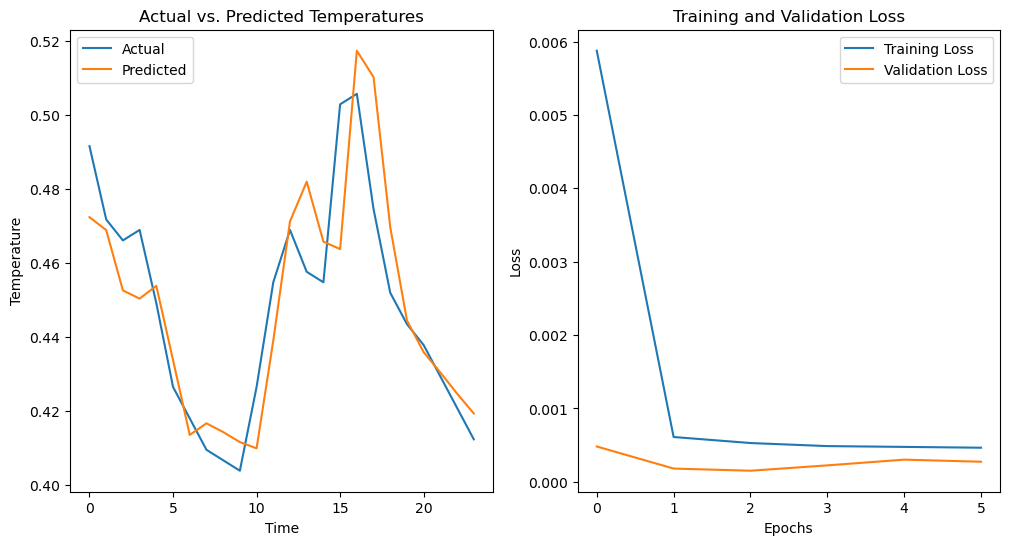

In [169]:
# Visualize predictions alongside actual temperatures
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(y_test, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.title('Actual vs. Predicted Temperatures')
plt.xlabel('Time')
plt.ylabel('Temperature')
plt.legend()

# Plot loss and validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

## Conclusions
***

**Mean Absolute Error (MAE):**
MAE measures the average absolute difference between predicted and actual temperatures.
We chose MAE because it provides a straightforward and intuitive measure of prediction accuracy, reflecting the average magnitude of errors in temperature prediction.
Lower values of MAE indicate better model performance, making it a suitable metric for assessing the model's predictive accuracy.

**Root Mean Squared Error (RMSE):**
RMSE represents the square root of the average squared difference between predicted and actual temperatures.
Like MAE, RMSE quantifies the prediction error but penalizes more significant errors due to the squaring operation.
We selected RMSE because it provides a measure of prediction accuracy sensitive to the magnitude of errors, making it particularly useful for detecting outliers or significant mistakes in temperature prediction.

**R-squared (R^2):**
R-squared measures the proportion of the variance in the temperature, which is explained by the features used in the model.
We included R-squared because it indicates how well the model captures the variation in temperature and the extent to which the chosen features contribute to the predictive performance.
A higher R-squared value indicates that a more significant proportion of the variance in temperature is predictable from the features, suggesting better model fit and predictive power.

## References
***

Aventura do Brasil. (2021). Brazil Climate: Vitoria. Retrieved from https://www.aventuradobrasil.com/info/brazil-climate/vitoria/

Haghighat, E., Juanes, R., & El Bahja, H. (2021). Physics-Informed Deep-Learning for Scientific Computing. arXiv. Retrieved from https://arxiv.org/abs/2005.08803

DeepLabV3+ Multiclass Semantic Segmentation. (n.d.). Keras.io. Retrieved from https://keras.io/examples/vision/deeplabv3_plus/

Made by:
Gonzales, Reginald Christian
Paddit, Keith Martin
Tandogon, Zen Adrian
Villapando, Christian James